In [1]:
import numpy as np
# 2d Eular Equation solver for oblique shock wave
# Parameters initialization
nmax = 22   # Number of grid points in y-direction
mmax = 42   # Number of grid points in x-direction
tmax = 400  # Number of time steps

# grid initialization
bigx = np.zeros((nmax+1, mmax+1)) # x-coordinate of grid points
bigy = np.zeros((nmax+1, mmax+1)) # y-coordinate of grid points
gridres = 2 * mmax // 40            # grid resolution
IS = 5 * gridres + 2                    # shock position
H = 2.4                             # height of the channel
L = 4.0                             # length of the channel
theta = 15.0                # angle of the oblique line  
dx = L/(mmax -2 )
dy = np.zeros((mmax+1))

# calculate the y-coordinate of grid points
dh = np.tan(theta*np.pi/180)*dx
for i in range(0,mmax + 1):
    if i < IS:
        dy[i] = H/(nmax - 2)
    else:
        dy[i] = (H - dh*(i + 1 - IS))/(nmax - 2)
for j in range(0,mmax+1):
    bigx[:,j] = (j-1)*dx
    for i in range(0,nmax+1):
        bigy[i, j] = dy[j] * (i-1)
        if j >= IS:
            bigy[i, j] += dx * (j-IS+1) * np.tan(theta * np.pi / 180.0)           

# calculate the center point
cell_centers_x = (bigx[:-1, :-1] + bigx[1:, 1:]) / 2
cell_centers_y = (bigy[:-1, :-1] + bigy[1:, 1:]) / 2

# save the grid points and judge whether the grid point is on the boundary
center_grid = np.zeros((nmax,mmax,3))

for i in range(nmax):
    for j in range(mmax):
        center_grid[i,j,0] = cell_centers_x[i,j]
        center_grid[i,j,1] = cell_centers_y[i,j]
        if i == 0 or i == nmax-1 or j == 0 or j == mmax-1:
            center_grid[i,j,2] = 1
        else:
            center_grid[i,j,2] = 0


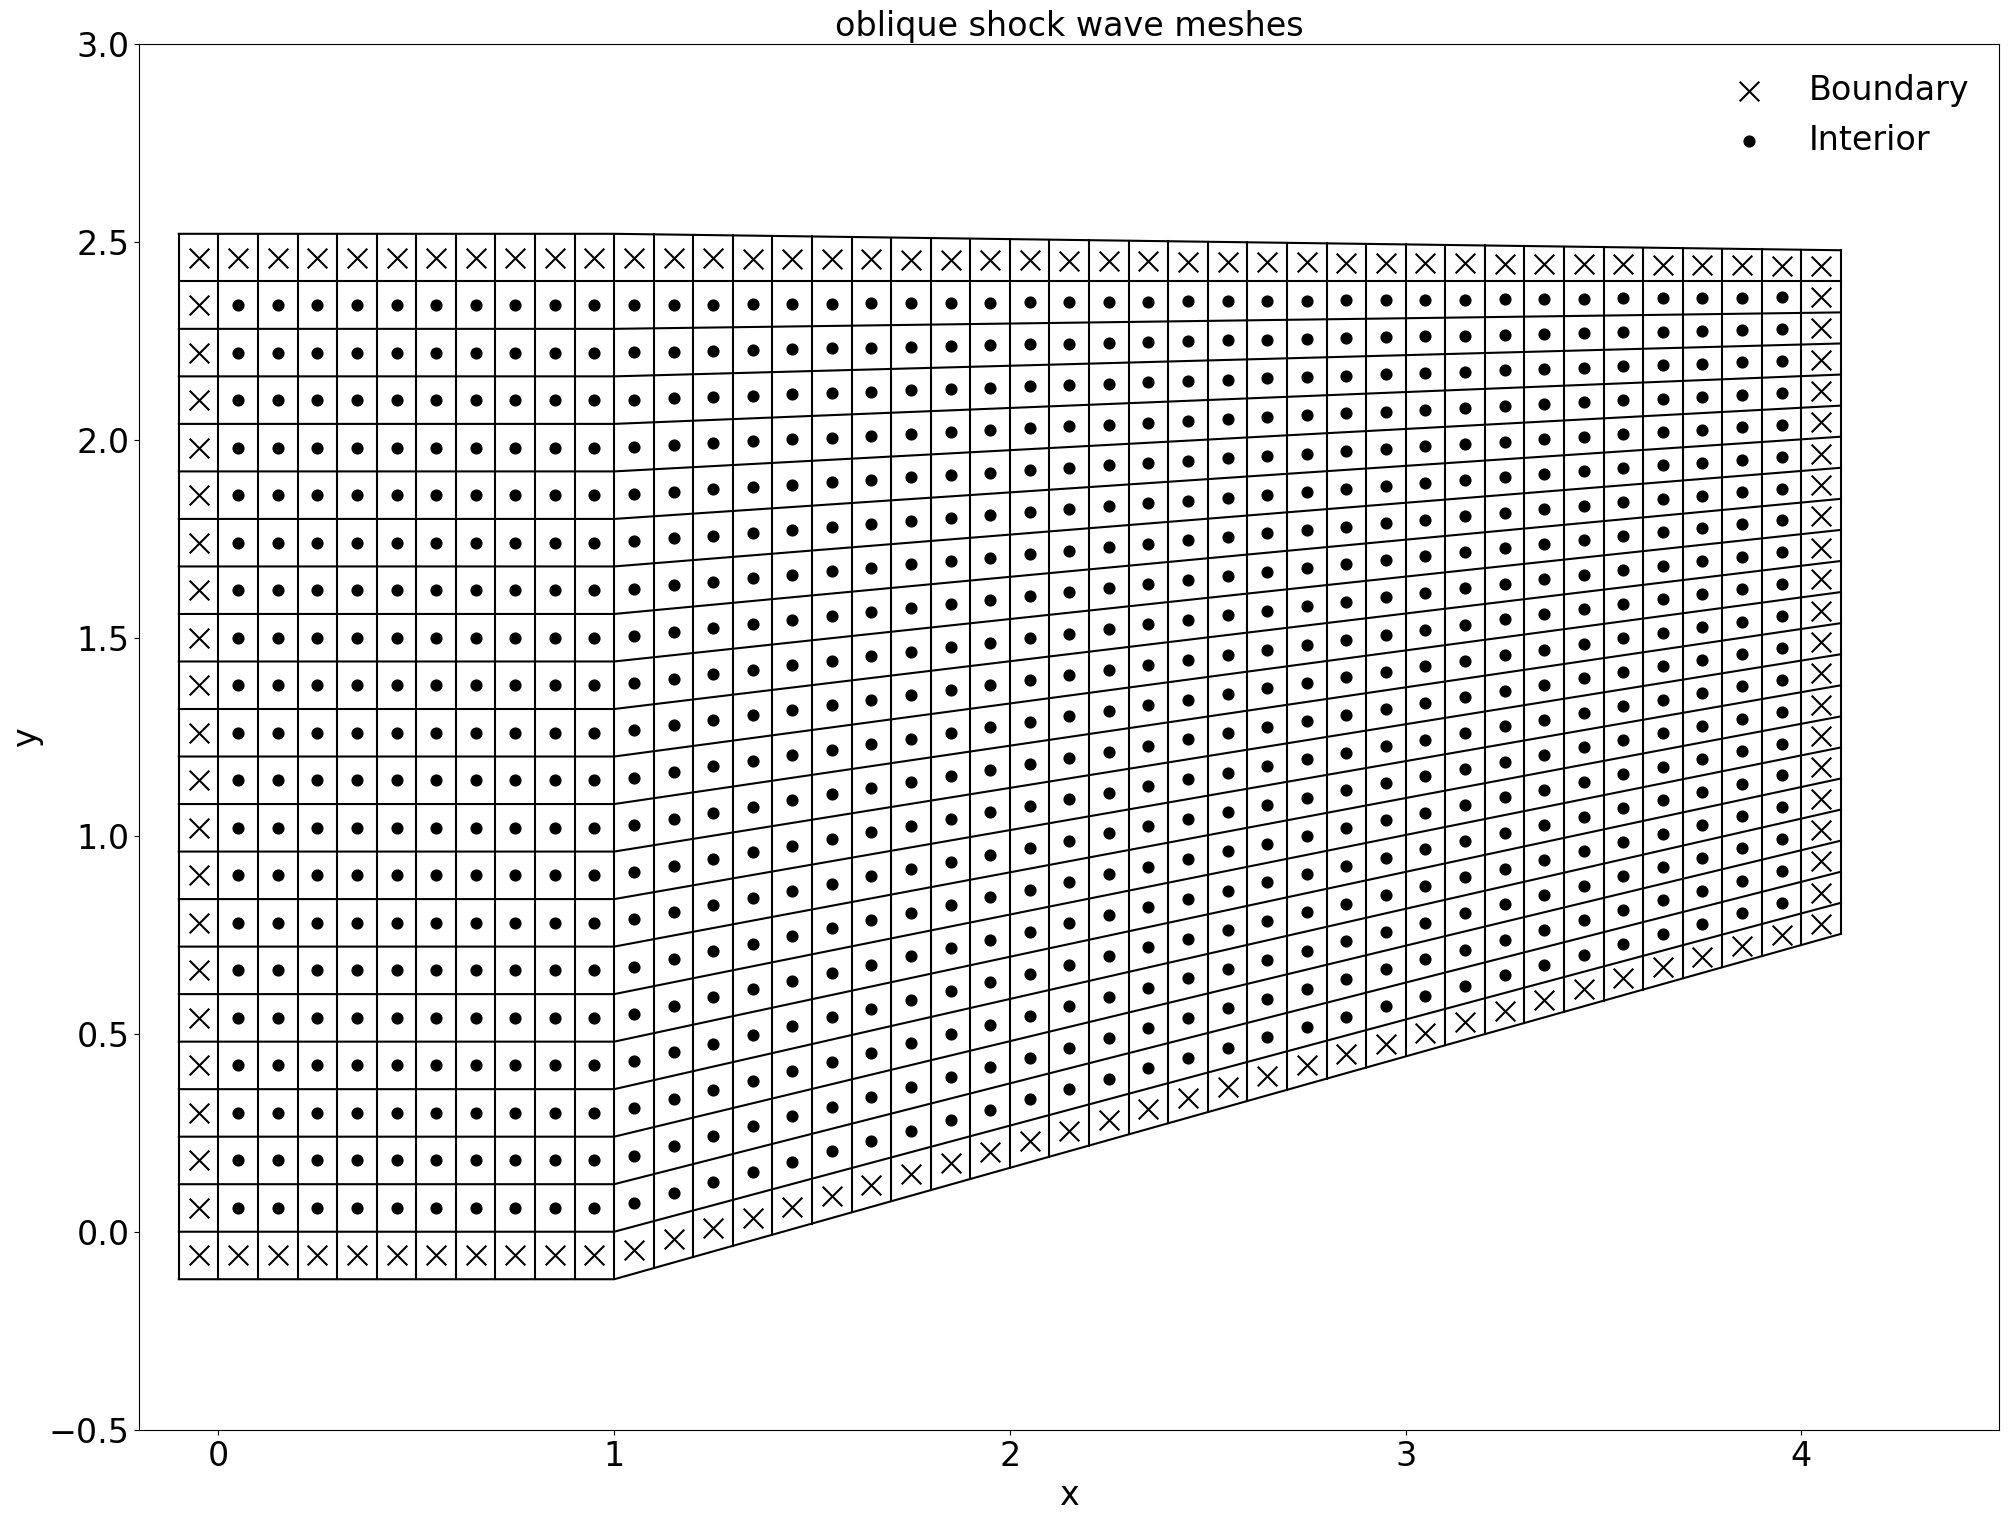

In [2]:
# 绘制网格可视化
import matplotlib.pyplot as plt
from matplotlib import cm

# 可视化网格
plt.figure(figsize=(24, 18))
for i in range(nmax+1):
    plt.plot(bigx[i, :], bigy[i, :], 'k')
for j in range(mmax+1):
    plt.plot(bigx[:, j], bigy[:, j], 'k')

# 初始化标志变量
boundary_label_added = False
interior_label_added = False

size_change = (mmax//40)**2

# 可视化格心
if mmax < 100:
    for i in range(nmax):
        for j in range(mmax):
            if center_grid[i, j, 2] == 1:
                if not boundary_label_added:
                    plt.scatter(center_grid[i, j, 0], center_grid[i, j, 1], marker='x', c='black', s=200/size_change, label='Boundary')
                    boundary_label_added = True
                else:
                    plt.scatter(center_grid[i, j, 0], center_grid[i, j, 1], marker='x', c='black', s=200/size_change)
            else:
                if not interior_label_added:
                    plt.scatter(center_grid[i, j, 0], center_grid[i, j, 1], marker='o', c='black', s=60/size_change, label='Interior')
                    interior_label_added = True
                else:
                    plt.scatter(center_grid[i, j, 0], center_grid[i, j, 1], marker='o', c='black', s=60/size_change)

plt.title("oblique shock wave meshes", fontsize=24)
plt.xlabel("x", fontsize=24)
plt.ylabel("y", fontsize=24)
plt.legend(loc='best', fontsize=24, frameon=False)
plt.xlim(-0.2, 4.5)
plt.ylim(-0.5, 3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [3]:
# parameters initialization
dis = 0.85                              # artificial dissipation coefficient
dymin = bigy[1,mmax-1] - bigy[0,mmax-1] # minimum grid spacing in y-direction
p1 = 99719                              # pressure at the inlet
R = 287.14                              # gas constant
T = 293.15                              # temperature
rho1 = p1/(R*T)                        # density at the inlet
# M1 = 2.9
gamma = 1.4                             # ratio of specific heats
c1 = np.sqrt(gamma*p1/rho1)             # speed of sound at the inlet
u1 = 686.47                             # velocity u at the inlet     
v1 = 0                                  # velocity v at the inlet    
e1 = rho1*(u1*u1 + v1*v1)/2 + p1/(gamma-1) # total energy at the inlet

U = np.zeros((4,nmax,mmax))
F = np.zeros((4,nmax,mmax))
E = np.zeros((4,nmax,mmax))
N = np.zeros((8,nmax,mmax))
S = np.zeros((4,nmax,mmax))
V = np.zeros((nmax,mmax))
newU = np.zeros((4,nmax,mmax))
newU2 = np.zeros((4,nmax,mmax))

rho = np.zeros((nmax,mmax))
u = np.zeros((nmax,mmax))
v = np.zeros((nmax,mmax))
p = np.zeros((nmax,mmax))
e = np.zeros((nmax,mmax))
c = np.zeros((nmax,mmax))


uu1 = np.zeros((nmax,mmax))
uu2 = np.zeros((nmax,mmax))
uu3 = np.zeros((nmax,mmax))
uu4 = np.zeros((nmax,mmax))
uc = np.zeros((nmax,mmax))
pterm = np.zeros((nmax,mmax))
ptermabs = np.zeros((nmax,mmax))
mindt = 0
dphi = np.zeros((nmax,mmax))
dmhi = np.zeros((nmax,mmax))
dphj = np.zeros((nmax,mmax))
dmhj = np.zeros((nmax,mmax))

Edot = np.zeros((4,nmax,mmax))
Epdot = np.zeros((4,nmax,mmax))
Emdot = np.zeros((4,nmax,mmax))
Fdot = np.zeros((4,nmax,mmax))
Fpdot = np.zeros((4,nmax,mmax))
Fmdot = np.zeros((4,nmax,mmax))

# 用于存储残差的列表
max_residuals = []  
l2_residuals = []

def det(a1,a2,a3,b1,b2,b3,c1,c2,c3):
    return a1*(b2*c3 - b3*c2) + a2*(b3*c1 - b1*c3) + a3*(b1*c2 - b2*c1) 



In [4]:
# calucate the angle of shock wave
# f(beta) = tan(theta) - 2*cot(beta)*[(M1^2*sin^2(beta)-1)/(M1^2*(gamma+cos(2*beta))+2)]

M1 = u1/c1
beta = 15*np.pi/180

def f(beta):
    return np.tan(theta*np.pi/180) - 2*(1/np.tan(beta))*((M1**2*np.sin(beta)**2-1)/(M1**2*(gamma+np.cos(2*beta))+2))

def df(beta):
    h = 1e-6
    return (f(beta+h)-f(beta-h))/(2*h)

learn_rate = 0.01
StopIteration = 1e-6

while abs(f(beta)) > StopIteration:
    beta = beta - learn_rate*f(beta)/df(beta)
    print(beta)

0.26422090865253756
0.2666538710798039
0.2690980339683677
0.27155315067503794
0.2740189691638559
0.27649523215006955
0.27898167725296064
0.28147803715405273
0.283984039763556
0.28649940839240085
0.2890238619307579
0.2915571150325997
0.29409887830566195
0.2966488585068112
0.2992067587419113
0.30177227867065715
0.304345114715331
0.30692496027344557
0.30951150593361965
0.31210443969435114
0.3147034471854118
0.3173082118915306
0.31991841537753973
0.32253373751461706
0.32515385670815056
0.3277784501251277
0.33040719392232903
0.3330397634735805
0.3356758335965516
0.3383150787784457
0.3409571733999796
0.3436017919569035
0.34624860928068096
0.3488973007545617
0.35154754252822923
0.35419901172836576
0.35685138666570315
0.3595043470383866
0.36215757413015015
0.3648107510053009
0.36746356269822694
0.37011569639750724
0.37276684162575136
0.37541669041339915
0.3780649374669019
0.38071128033171536
0.3833554195485646
0.38599705880423457
0.38863590507592843
0.39127166877015324
0.39390406385390864
0.39

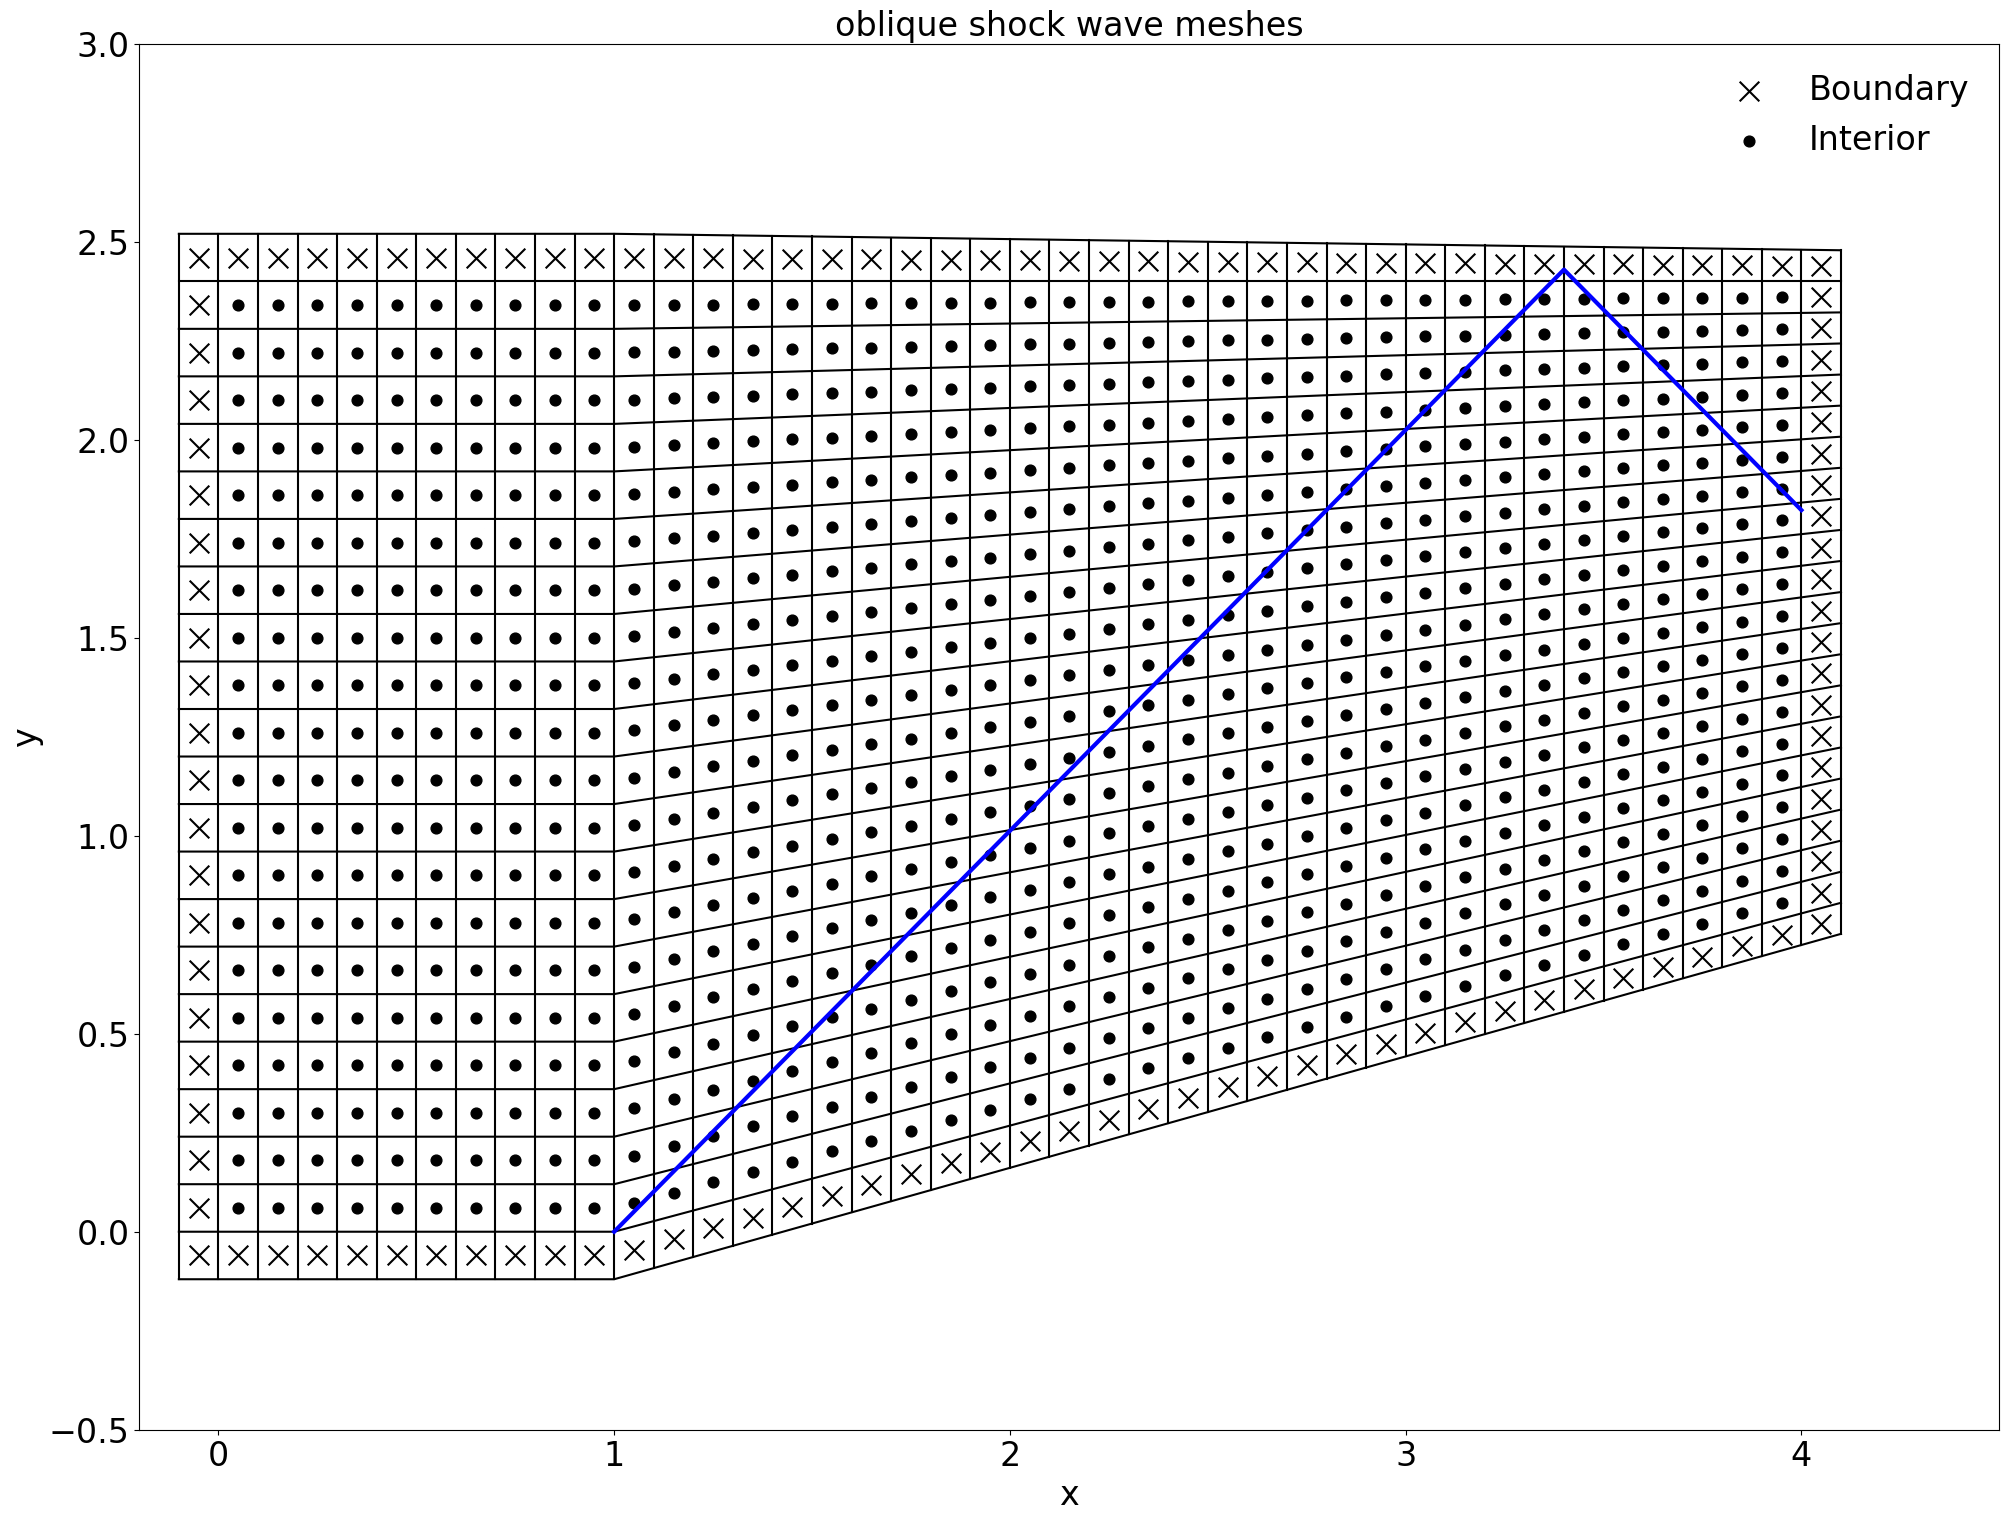

In [5]:
# 绘制网格可视化
import matplotlib.pyplot as plt
from matplotlib import cm

# 可视化网格
plt.figure(figsize=(24, 18))
for i in range(nmax+1):
    plt.plot(bigx[i, :], bigy[i, :], 'k')
for j in range(mmax+1):
    plt.plot(bigx[:, j], bigy[:, j], 'k')

# 初始化标志变量
boundary_label_added = False
interior_label_added = False

size_change = (mmax//40)**2

# 可视化格心
if mmax<100:
    for i in range(nmax):
        for j in range(mmax):
            if center_grid[i, j, 2] == 1:
                if not boundary_label_added:
                    plt.scatter(center_grid[i, j, 0], center_grid[i, j, 1], marker='x', c='black', s=200/size_change, label='Boundary')
                    boundary_label_added = True
                else:
                    plt.scatter(center_grid[i, j, 0], center_grid[i, j, 1], marker='x', c='black', s=200/size_change)
            else:
                if not interior_label_added:
                    plt.scatter(center_grid[i, j, 0], center_grid[i, j, 1], marker='o', c='black', s=60/size_change, label='Interior')
                    interior_label_added = True
                else:
                    plt.scatter(center_grid[i, j, 0], center_grid[i, j, 1], marker='o', c='black', s=60/size_change)

# 可视化激波
wave_x = bigx[0,IS-1:mmax]
tmp = 0
wave_y = []
for i in range(IS-1,mmax):
    if tmp+np.tan(beta)*dx > max(bigy[:,i]) or tmp+np.tan(beta)*dx < min(bigy[:,i]):
        beta = -beta
    wave_y.append(tmp)
    tmp = np.tan(beta)*dx+tmp

plt.plot(wave_x,wave_y,'blue',linewidth=3)


plt.title("oblique shock wave meshes", fontsize=24)
plt.xlabel("x", fontsize=24)
plt.ylabel("y", fontsize=24)
plt.legend(loc='best', fontsize=24, frameon=False)
plt.xlim(-0.2, 4.5)
plt.ylim(-0.5, 3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [6]:
# calculate the normal vector and area of each cell

for i in range(0,nmax):
    for j in range(0,mmax):
        ndx = bigx[i,j+1] - bigx[i,j]
        ndy = bigy[i,j+1] - bigy[i,j]
        area = np.sqrt(ndx*ndx + ndy*ndy)
        S[0,i,j] = area
        N[0,i,j] = ndy/area
        N[1,i,j] = -ndx/area
        ndx = bigx[i+1,j+1] - bigx[i,j+1]
        ndy = bigy[i+1,j+1] - bigy[i,j+1]
        area = np.sqrt(ndx*ndx + ndy*ndy)
        S[1,i,j] = area
        N[2,i,j] = ndy/area
        N[3,i,j] = -ndx/area
        ndx = bigx[i+1,j] - bigx[i+1,j+1]
        ndy = bigy[i+1,j] - bigy[i+1,j+1]
        area = np.sqrt(ndx*ndx + ndy*ndy)
        S[2,i,j] = area
        N[4,i,j] = ndy/area
        N[5,i,j] = -ndx/area
        ndx = bigx[i,j] - bigx[i+1,j]
        ndy = bigy[i,j] - bigy[i+1,j]
        area = np.sqrt(ndx*ndx + ndy*ndy)
        S[3,i,j] = area
        N[6,i,j] = ndy/area
        N[7,i,j] = -ndx/area
        S1 = det(bigx[i,j],bigy[i,j],1,bigx[i+1,j+1],bigy[i+1,j+1],1,bigx[i+1,j],bigy[i+1,j],1)
        S2 = det(bigx[i,j],bigy[i,j],1,bigx[i,j+1],bigy[i,j+1],1,bigx[i+1,j+1],bigy[i+1,j+1],1)
        V[i,j] = 0.5*(abs(S1) + abs(S2))




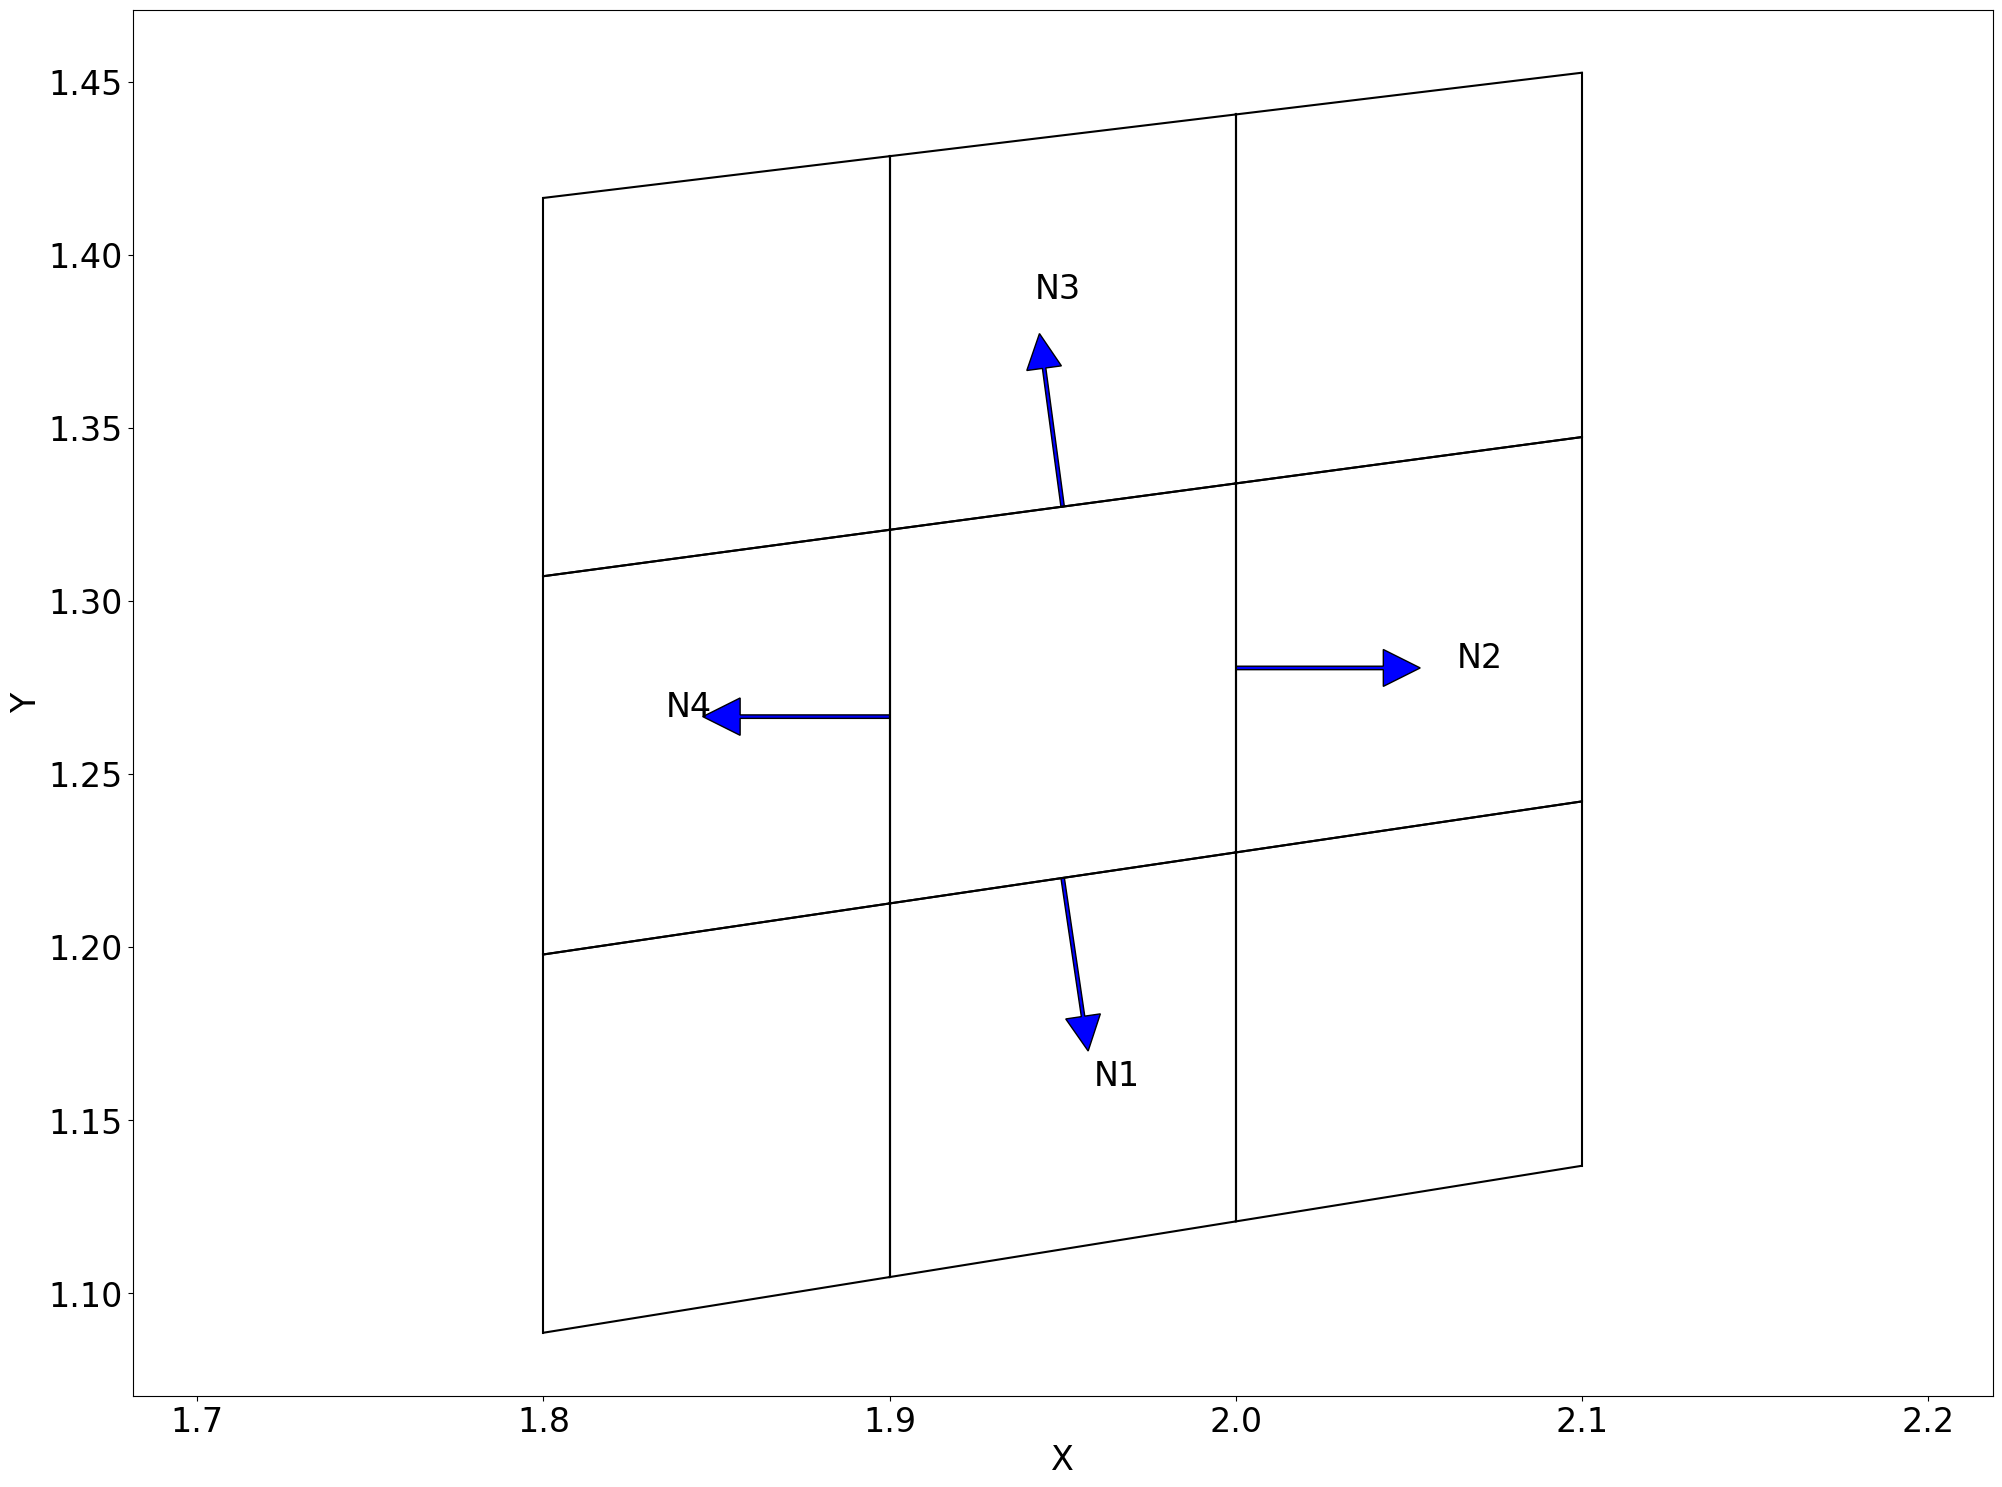

In [7]:

# 确定中心单元格及其周边单元格的坐标
i, j = 10, 20  # 中心单元格的索引
x_near, y_near = 1, 1  # 邻近单元格的范围

plt.figure(figsize=(24, 18))

# 绘制单元格
for di in range(-x_near, x_near + 1):
    for dj in range(-y_near, y_near + 1):
        corners_x = [bigx[i+di, j+dj], bigx[i+di, j+dj+1], bigx[i+di+1, j+dj+1], bigx[i+di+1, j+dj]]
        corners_y = [bigy[i+di, j+dj], bigy[i+di, j+dj+1], bigy[i+di+1, j+dj+1], bigy[i+di+1, j+dj]]
        plt.plot([corners_x[0], corners_x[1]], [corners_y[0], corners_y[1]], 'k-')
        plt.plot([corners_x[1], corners_x[2]], [corners_y[1], corners_y[2]], 'k-')
        plt.plot([corners_x[2], corners_x[3]], [corners_y[2], corners_y[3]], 'k-')
        plt.plot([corners_x[3], corners_x[0]], [corners_y[3], corners_y[0]], 'k-')


# 用于确定箭头长度的比例因子
arrow_length_factor = 0.4
arrow_scale_factor = 0.1

for k in range(4):
    if k == 0:
        mid_x = (bigx[i, j] + bigx[i, j+1]) / 2
        mid_y = (bigy[i, j] + bigy[i, j+1]) / 2
        edge_length = np.sqrt((bigx[i, j] - bigx[i, j+1])**2 + (bigy[i, j] - bigy[i, j+1])**2)
    elif k == 1:
        mid_x = (bigx[i, j+1] + bigx[i+1, j+1]) / 2
        mid_y = (bigy[i, j+1] + bigy[i+1, j+1]) / 2
        edge_length = np.sqrt((bigx[i, j+1] - bigx[i+1, j+1])**2 + (bigy[i, j+1] - bigy[i+1, j+1])**2)
    elif k == 2:
        mid_x = (bigx[i+1, j+1] + bigx[i+1, j]) / 2
        mid_y = (bigy[i+1, j+1] + bigy[i+1, j]) / 2
        edge_length = np.sqrt((bigx[i+1, j+1] - bigx[i+1, j])**2 + (bigy[i+1, j+1] - bigy[i+1, j])**2)
    else:  # k == 3
        mid_x = (bigx[i+1, j] + bigx[i, j]) / 2
        mid_y = (bigy[i+1, j] + bigy[i, j]) / 2
        edge_length = np.sqrt((bigx[i+1, j] - bigx[i, j])**2 + (bigy[i+1, j] - bigy[i, j])**2)

    # 自适应地调整箭头的大小
    head_width = arrow_scale_factor * edge_length
    head_length = arrow_scale_factor * edge_length

    # 缩放法线向量的长度
    norm_length = arrow_length_factor * edge_length
    scaled_nx = N[2*k, i, j] * norm_length
    scaled_ny = N[2*k+1, i, j] * norm_length

    plt.arrow(mid_x, mid_y, scaled_nx, scaled_ny, head_width=head_width, head_length=head_length, fc='blue', ec='black')
    plt.text(mid_x + 1.5*scaled_nx, mid_y + 1.5*scaled_ny, f'N{k+1}', color="black",fontsize=24)

plt.xlabel('X',fontsize=24)
plt.ylabel('Y',fontsize=24)
plt.axis('equal')
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [8]:
# calculate the initial condition
U[0,:,:] = rho1
U[1,:,:] = rho1*u1
U[2,:,:] = rho1*v1
U[3,:,:] = e1
E[0,:,:] = rho1*u1
E[1,:,:] = rho1*u1*u1 + p1
E[2,:,:] = rho1*u1*v1
E[3,:,:] = (e1 + p1)*u1
F[0,:,:] = rho1*v1
F[1,:,:] = rho1*u1*v1
F[2,:,:] = rho1*v1*v1 + p1
F[3,:,:] = (e1 + p1)*v1


newU2 = U.copy()
newU = U.copy()

In [9]:
# Maccormack method

from tqdm import tqdm

for t in tqdm(range(0,tmax)):


    # Predictor
    # boundary condition
    # mirror boundary condition

    U[:,:,mmax - 1] = 2*U[:,:,mmax-2] - U[:,:,mmax-3]
    U[0,0,1:mmax-1] = U[0,1,1:mmax-1]
    U[1,0,1:mmax-1] = U[1,1,1:mmax-1]
    U[2,0,1:mmax-1] = -U[2,1,1:mmax-1]
    U[3,0,1:mmax-1] = U[3,1,1:mmax-1]
    theta = 15*np.pi/180
    cthe = np.cos(theta)
    sthe = np.sin(theta)
    vn = U[1,1,IS-1:mmax]*sthe - U[2,1,IS-1:mmax]*cthe 
    vt = U[1,1,IS-1:mmax]*cthe + U[2,1,IS-1:mmax]*sthe 
    U[1,0,IS-1:mmax] = vt*cthe - vn*sthe
    U[2,0,IS-1:mmax] = vt*sthe + vn*cthe
    U[0,0,IS-1:mmax] = U[0,1,IS-1:mmax]
    U[3,0,IS-1:mmax] = U[3,1,IS-1:mmax]
    U[0,nmax-1,:] = U[0,nmax-2,:]
    U[1,nmax-1,:] = U[1,nmax-2,:]
    U[2,nmax-1,:] = -U[2,nmax-2,:]
    U[3,nmax-1,:] = U[3,nmax-2,:]

    #calculate the parameters
    rho[:,:] = U[0,:,:]
    u[:,:] = U[1,:,:]/rho[:,:]
    v[:,:] = U[2,:,:]/rho[:,:]
    e[:,:] = U[3,:,:]
    p[:,:] = (gamma - 1)*(e[:,:] - rho[:,:]*(u[:,:]*u[:,:] + v[:,:]*v[:,:])/2)
    E[0,:,:] = rho[:,:]*u[:,:]
    E[1,:,:] = rho[:,:]*u[:,:]*u[:,:] + p[:,:]
    E[2,:,:] = rho[:,:]*u[:,:]*v[:,:]
    E[3,:,:] = (e[:,:] + p[:,:])*u[:,:]
    F[0,:,:] = rho[:,:]*v[:,:]
    F[1,:,:] = rho[:,:]*u[:,:]*v[:,:]
    F[2,:,:] = rho[:,:]*v[:,:]*v[:,:] + p[:,:]
    F[3,:,:] = (e[:,:] + p[:,:])*v[:,:]
    
    # calculate the time step
    mindt = 100
    c[:,:] = (gamma*p[:,:]/rho[:,:])**0.5
    for i in range(1,nmax-1):
        for j in range(1,mmax-1):
            nowdt = 1/(abs(u[i,j])/dx + abs(v[i,j])/dymin + c[i,j]*(1/dx/dx+1/dymin/dymin)**0.5)
            if mindt > nowdt:
                mindt = nowdt

    # calculate the flux at each cell         
    uu1[:,:] = abs(u[:,:]*N[0,:,:] + v[:,:]*N[1,:,:])
    uu2[:,:] = abs(u[:,:]*N[2,:,:] + v[:,:]*N[3,:,:])
    uu3[:,:] = abs(u[:,:]*N[4,:,:] + v[:,:]*N[5,:,:])
    uu4[:,:] = abs(u[:,:]*N[6,:,:] + v[:,:]*N[7,:,:])
    uc[:,:] = uu2[:,:] + c[:,:]
    for i in range(1,nmax-1):
        for j in range(1,mmax-1):
            pterm[i,j] = p[i,j+1] + 2*p[i,j] + p[i,j-1]
            ptermabs[i,j] = abs(p[i,j+1] - 2*p[i,j] + p[i,j-1])
            dphi[i,j] = dis*uc[i,j]*(ptermabs[i,j]/pterm[i,j])
    uc[:,:] = uu4[:,:] + c[:,:]
    for i in range(1,nmax-1):
        for j in range(1,mmax-1):
            pterm[i,j] = p[i,j] + 2*p[i,j-1] + p[i,j-2]
            if j == 1:
                ptermabs[i,j] = 0
            else:
                ptermabs[i,j] = abs(p[i,j] - 2*p[i,j-1] + p[i,j-2])
            dmhi[i,j] = dis*uc[i,j]*(ptermabs[i,j]/pterm[i,j])   
    uc[:,:] = uu3[:,:] + c[:,:]
    for i in range(1,nmax-1):
        for j in range(1,mmax-1):
            pterm[i,j] = p[i+1,j] + 2*p[i,j] + p[i-1,j]
            ptermabs[i,j] = abs(p[i+1,j] - 2*p[i,j] + p[i-1,j])
            dphj[i,j] = dis*uc[i,j]*(ptermabs[i,j]/pterm[i,j])
    uc[:,:] = uu1[:,:] + c[:,:]
    for i in range(1,nmax-1):
        for j in range(1,mmax-1):
            pterm[i,j] = p[i,j] + 2*p[i-1,j] + p[i-2,j]
            if i == 1:
                ptermabs[i,j] = 0
            else:
                ptermabs[i,j] = abs(p[i,j] - 2*p[i-1,j] + p[i-2,j])
            dmhj[i,j] = dis*uc[i,j]*(ptermabs[i,j]/pterm[i,j])       
            
    
    for i in range(1,nmax-1):
        for j in range(1,mmax-1):
            Epdot[:,i,j] = E[:,i,j+1]*N[2,i,j] + F[:,i,j+1]*N[3,i,j]
            Edot[:,i,j] = E[:,i,j]*N[6,i,j] + F[:,i,j]*N[7,i,j]
            Fpdot[:,i,j] = E[:,i+1,j]*N[4,i,j] + F[:,i+1,j]*N[5,i,j]
            Fdot[:,i,j] = E[:,i,j]*N[0,i,j] + F[:,i,j]*N[1,i,j]
            newU[:,i,j] = U[:,i,j] - mindt/V[i,j]*(
                  (Epdot[:,i,j] - dphi[i,j]*(U[:,i,j+1]-U[:,i,j]))*S[1,i,j]
                + (Edot[:,i,j] + dmhi[i,j]*(U[:,i,j] - U[:,i,j-1]))*S[3,i,j] 
                + (Fpdot[:,i,j] - dphj[i,j]*(U[:,i+1,j] - U[:,i,j]))*S[2,i,j]
                + (Fdot[:,i,j] + dmhj[i,j]*(U[:,i,j] - U[:,i-1,j]))*S[0,i,j])

     

    # corrector
    newU[:,:,mmax - 1] = 2*newU[:,:,mmax-2] - newU[:,:,mmax-3]
    newU[0,0,1:mmax-1] = newU[0,1,1:mmax-1]
    newU[1,0,1:mmax-1] = newU[1,1,1:mmax-1]
    newU[2,0,1:mmax-1] = -newU[2,1,1:mmax-1]
    newU[3,0,1:mmax-1] = newU[3,1,1:mmax-1]
    theta = 15.0*np.pi/180
    cthe = np.cos(theta)
    sthe = np.sin(theta)
    vn = newU[1,1,IS-1:mmax]*sthe - newU[2,1,IS-1:mmax]*cthe 
    vt = newU[1,1,IS-1:mmax]*cthe + newU[2,1,IS-1:mmax]*sthe 
    newU[1,0,IS-1:mmax] = vt*cthe - vn*sthe
    newU[2,0,IS-1:mmax] = vt*sthe + vn*cthe
    newU[0,0,IS-1:mmax] = newU[0,1,IS-1:mmax]
    newU[3,0,IS-1:mmax] = newU[3,1,IS-1:mmax]
    newU[0,nmax-1,:] = newU[0,nmax-2,:]
    newU[1,nmax-1,:] = newU[1,nmax-2,:]
    newU[2,nmax-1,:] = -newU[2,nmax-2,:]
    newU[3,nmax-1,:] = newU[3,nmax-2,:]
    
    #计算参数
    rho[:,:] = newU[0,:,:]
    u[:,:] = newU[1,:,:]/rho[:,:]
    v[:,:] = newU[2,:,:]/rho[:,:]
    e[:,:] = newU[3,:,:]
    p[:,:] = (gamma - 1)*(e[:,:] - rho[:,:]*(u[:,:]*u[:,:] + v[:,:]*v[:,:])/2)
    E[0,:,:] = rho[:,:]*u[:,:]
    E[1,:,:] = rho[:,:]*u[:,:]*u[:,:] + p[:,:]
    E[2,:,:] = rho[:,:]*u[:,:]*v[:,:]
    E[3,:,:] = (e[:,:] + p[:,:])*u[:,:]
    F[0,:,:] = rho[:,:]*v[:,:]
    F[1,:,:] = rho[:,:]*u[:,:]*v[:,:]
    F[2,:,:] = rho[:,:]*v[:,:]*v[:,:] + p[:,:]
    F[3,:,:] = (e[:,:] + p[:,:])*v[:,:]

    uu1[:,:] = abs(u[:,:]*N[0,:,:] + v[:,:]*N[1,:,:])
    uu2[:,:] = abs(u[:,:]*N[2,:,:] + v[:,:]*N[3,:,:])
    uu3[:,:] = abs(u[:,:]*N[4,:,:] + v[:,:]*N[5,:,:])
    uu4[:,:] = abs(u[:,:]*N[6,:,:] + v[:,:]*N[7,:,:])
    uc[:,:] = uu2[:,:] + c[:,:]
    for i in range(1,nmax-1):
        for j in range(1,mmax-1):
            if j == 1:
                ptermabs[i,j] = 0
                pterm[i,j] = 1
            else:
                pterm[i,j] = p[i,j] + 2*p[i,j-1] + p[i,j-2]
                ptermabs[i,j] = abs(p[i,j] - 2*p[i,j-1] + p[i,j-2])
            dphi[i,j] = dis*uc[i,j]*(ptermabs[i,j]/pterm[i,j])
    uc[:,:] = uu4[:,:] + c[:,:]
    for i in range(1,nmax-1):
        for j in range(1,mmax-1):
            if j < 3:
                ptermabs[i,j] = 0
            else:
                ptermabs[i,j] = abs(p[i,j-1] - 2*p[i,j-2] + p[i,j-3])
                pterm[i,j] = p[i,j-1] + 2*p[i,j-2] + p[i,j-3]
            dmhi[i,j] = dis*uc[i,j]*(ptermabs[i,j]/pterm[i,j])   
    uc[:,:] = uu3[:,:] + c[:,:]
    for i in range(1,nmax-1):
        for j in range(1,mmax-1):
            if i == 1:
                ptermabs[i,j] = 0
            else:
                ptermabs[i,j] = abs(p[i,j] - 2*p[i-1,j] + p[i-2,j])
                pterm[i,j] = p[i,j] + 2*p[i-1,j] + p[i-2,j]
            dphj[i,j] = dis*uc[i,j]*(ptermabs[i,j]/pterm[i,j])
    uc[:,:] = uu1[:,:] + c[:,:]
    for i in range(1,nmax-1):
        for j in range(1,mmax-1):
            if i  < 3:
                ptermabs[i,j] = 0
            else:
                ptermabs[i,j] = abs(p[i-1,j] - 2*p[i-2,j] + p[i-3,j])
                pterm[i,j] = p[i-1,j] + 2*p[i-2,j] + p[i-3,j]
            dmhj[i,j] = dis*uc[i,j]*(ptermabs[i,j]/pterm[i,j])   

    for i in range(1,nmax-1):
        for j in range(1,mmax-1):
            Edot[:,i,j] = E[:,i,j]*N[2,i,j] + F[:,i,j]*N[3,i,j]
            Emdot[:,i,j] = E[:,i,j-1]*N[6,i,j] + F[:,i,j-1]*N[7,i,j]
            Fdot[:,i,j] = E[:,i,j]*N[4,i,j] + F[:,i,j]*N[5,i,j]
            Fmdot[:,i,j] = E[:,i-1,j]*N[0,i,j] + F[:,i-1,j]*N[1,i,j]
            newU2[:,i,j] = 0.5*(newU[:,i,j] + U[:,i,j] - mindt/V[i,j]*(
                  (Edot[:,i,j] - dphi[i,j]*(U[:,i,j+1]-U[:,i,j]))*S[1,i,j]
                + (Emdot[:,i,j] + dmhi[i,j]*(U[:,i,j] - U[:,i,j-1]))*S[3,i,j] 
                + (Fdot[:,i,j] - dphj[i,j]*(U[:,i+1,j] - U[:,i,j]))*S[2,i,j]
                + (Fmdot[:,i,j] + dmhj[i,j]*(U[:,i,j] - U[:,i-1,j]))*S[0,i,j]))
    
    max_residual = np.max(np.abs((newU2[3,:,:] - U[3,:,:])/U[3,:,:]))
    max_residuals.append(max_residual)

    l2_residual = np.linalg.norm(newU2[3,:,:] - U[3,:,:])/np.linalg.norm(U[3,:,:])/np.sqrt(nmax*mmax)
    l2_residuals.append(l2_residual)


    U[:,:,:] = 0.5*(newU2[:,:,:] + U[:,:,:])
    tes = 1

100%|██████████| 400/400 [00:26<00:00, 15.05it/s]


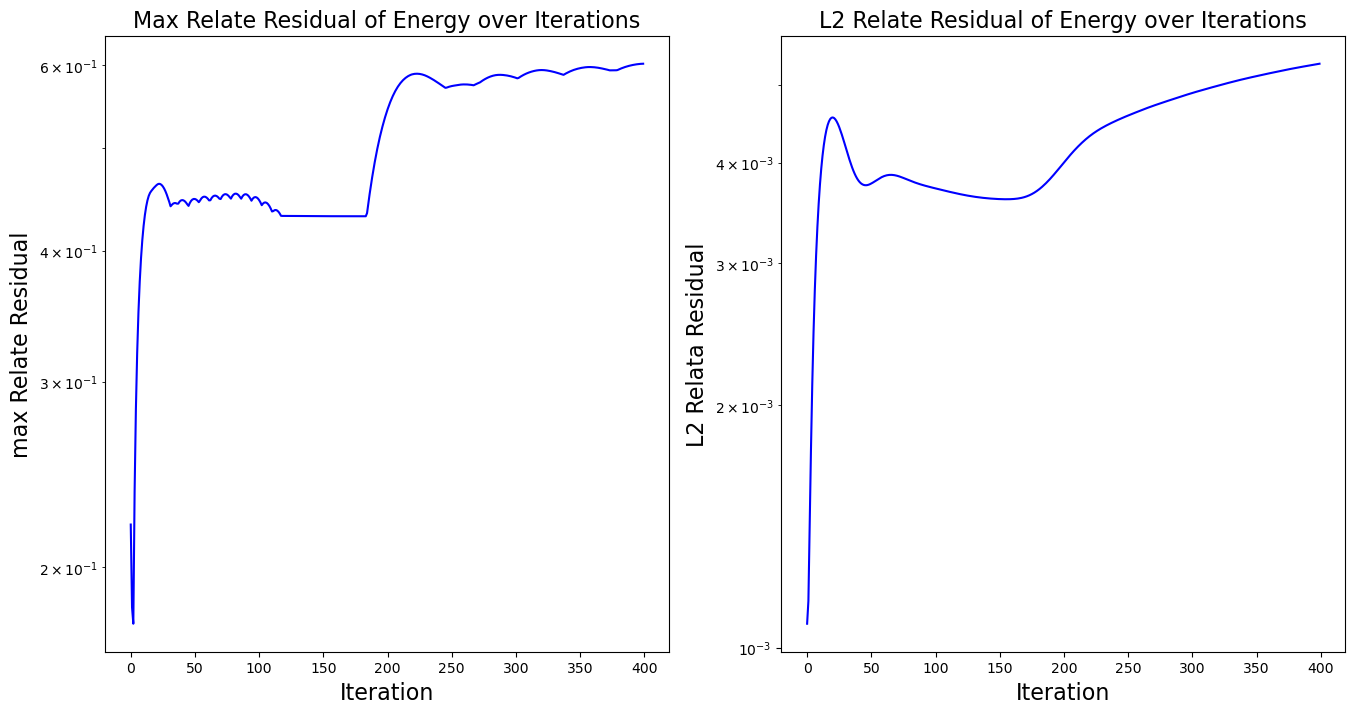

In [10]:
import matplotlib.pyplot as plt 
# 绘制残差曲线

fig,axs = plt.subplots(1,2,figsize=(16,8))
axs[0].plot(max_residuals,color="blue")
axs[0].set_yscale('log')  # 对数尺度可以更清晰地展示收敛性
axs[0].set_xlabel('Iteration',fontsize=16)
axs[0].set_ylabel('max Relate Residual',fontsize=16)
axs[0].set_title('Max Relate Residual of Energy over Iterations',fontsize=16)

axs[1].plot(l2_residuals,color="blue")
axs[1].set_yscale('log')  # 对数尺度可以更清晰地展示收敛性
axs[1].set_xlabel('Iteration',fontsize=16)
axs[1].set_ylabel('L2 Relata Residual',fontsize=16)
axs[1].set_title('L2 Relate Residual of Energy over Iterations',fontsize=16)

plt.show()



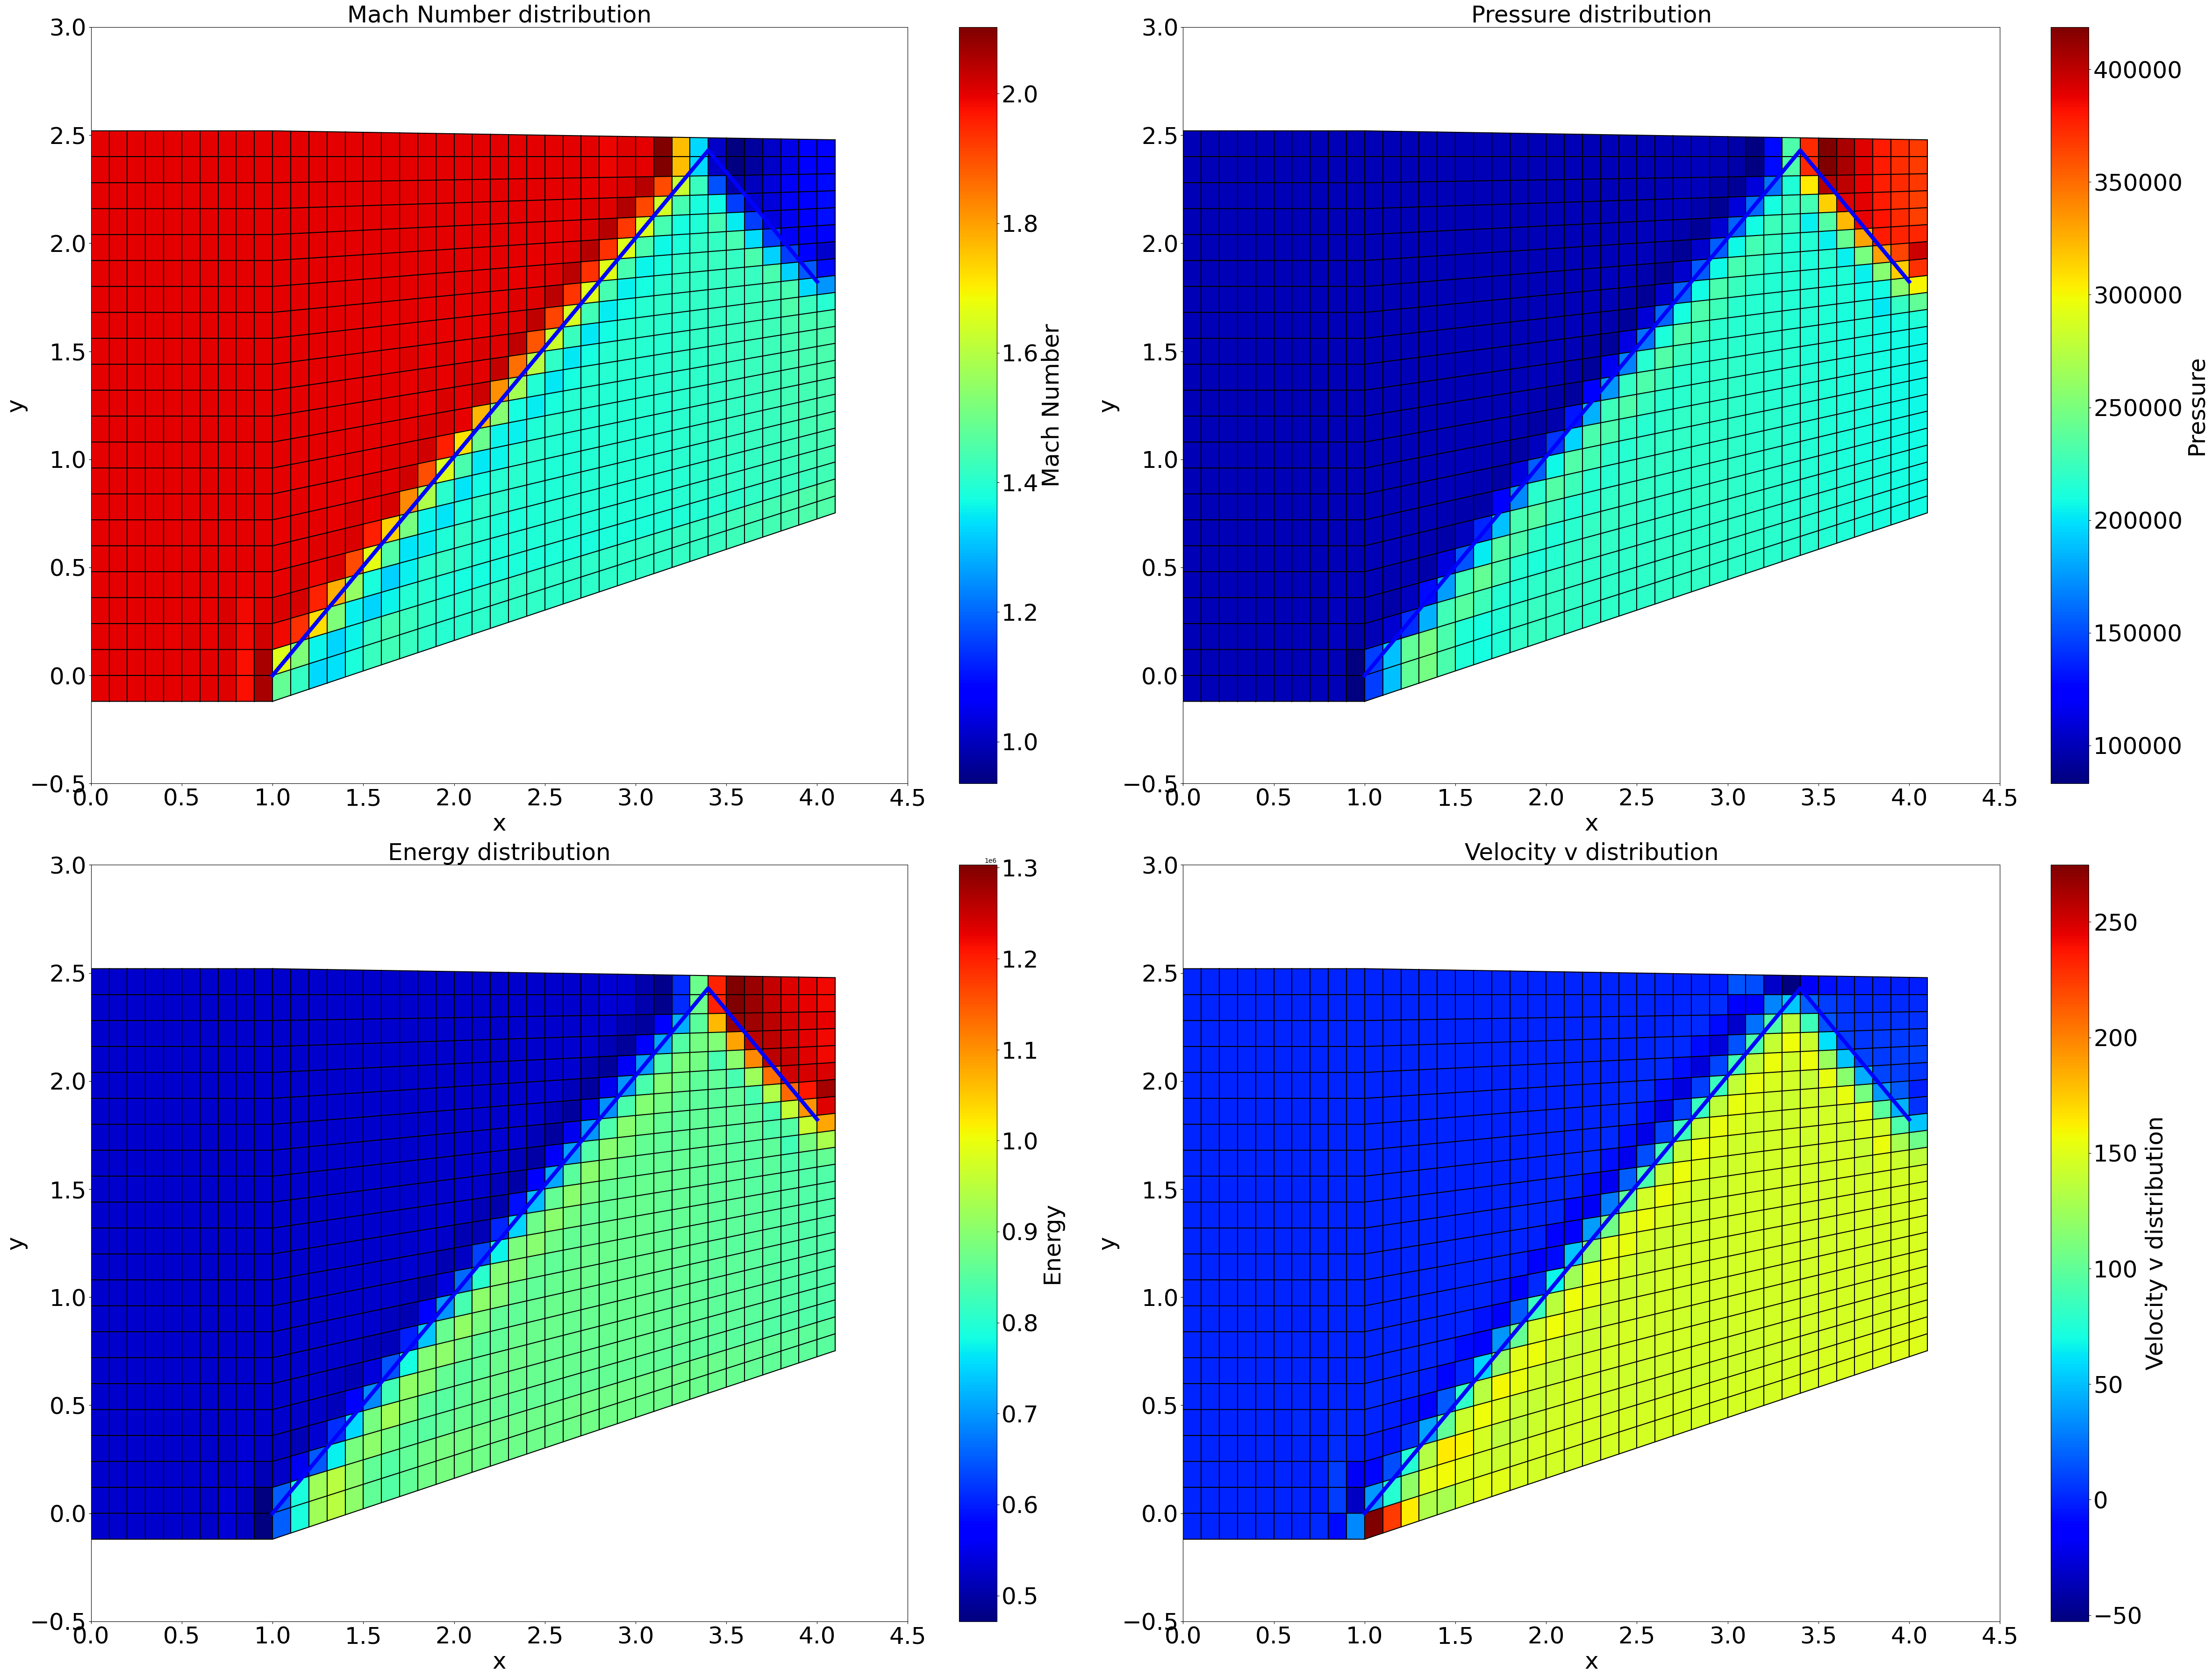

In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm

# 可视化网格
fig, axs = plt.subplots(2, 2, figsize=(48, 36))

for i in range(nmax+1):
    axs[0,0].plot(bigx[i, :], bigy[i, :], 'k')
    axs[0,1].plot(bigx[i, :], bigy[i, :], 'k')
    axs[1,0].plot(bigx[i, :], bigy[i, :], 'k')
    axs[1,1].plot(bigx[i, :], bigy[i, :], 'k')
for j in range(mmax+1):
    axs[0,0].plot(bigx[:, j], bigy[:, j], 'k')
    axs[0,1].plot(bigx[:, j], bigy[:, j], 'k')
    axs[1,0].plot(bigx[:, j], bigy[:, j], 'k')
    axs[1,1].plot(bigx[:, j], bigy[:, j], 'k')

axs[0,0].plot(wave_x,wave_y,'blue',linewidth=6)
axs[0,1].plot(wave_x,wave_y,'blue',linewidth=6)
axs[1,0].plot(wave_x,wave_y,'blue',linewidth=6)
axs[1,1].plot(wave_x,wave_y,'blue',linewidth=6)

# 注意：确保U和p的数据结构正确
mech = axs[0,0].pcolormesh(bigx, bigy, u[:,:]/c[:,:], shading='auto', cmap='jet')  
cbar_mech = fig.colorbar(mech, ax=axs[0,0])
cbar_mech.set_label("Mach Number", fontsize=36)
cbar_mech.ax.tick_params(labelsize=36)

axs[0,0].set_title('Mach Number distribution', fontsize=36)
axs[0,0].set_xlabel('x', fontsize=36)
axs[0,0].set_ylabel('y', fontsize=36)
axs[0,0].set_xlim(0, 4.5)
axs[0,0].set_ylim(-0.5, 3)

pressure = axs[0,1].pcolormesh(bigx, bigy, p[:, :], shading='auto', cmap='jet')
cbar_pressure = fig.colorbar(pressure, ax=axs[0,1])
cbar_pressure.set_label("Pressure", fontsize=36)
cbar_pressure.ax.tick_params(labelsize=36)

axs[0,1].set_title('Pressure distribution', fontsize=36)
axs[0,1].set_xlabel('x', fontsize=36)
axs[0,1].set_ylabel('y', fontsize=36)
axs[0,1].set_xlim(0, 4.5)
axs[0,1].set_ylim(-0.5, 3)

energy = axs[1,0].pcolormesh(bigx, bigy, e[:,:], shading='auto', cmap='jet')
cbar_energy = fig.colorbar(energy, ax=axs[1,0])
cbar_energy.set_label("Energy", fontsize=36)
cbar_energy.ax.tick_params(labelsize=36)

axs[1,0].set_title('Energy distribution', fontsize=36)
axs[1,0].set_xlabel('x', fontsize=36)
axs[1,0].set_ylabel('y', fontsize=36)
axs[1,0].set_xlim(0, 4.5)
axs[1,0].set_ylim(-0.5, 3)

density = axs[1,1].pcolormesh(bigx, bigy, v[:, :], shading='auto', cmap='jet')
cbar_density = fig.colorbar(density, ax=axs[1,1])
cbar_density.set_label("Velocity v distribution", fontsize=36)
cbar_density.ax.tick_params(labelsize=36)

axs[1,1].set_title('Velocity v distribution', fontsize=36)
axs[1,1].set_xlabel('x', fontsize=36)
axs[1,1].set_ylabel('y', fontsize=36)
axs[1,1].set_xlim(0, 4.5)
axs[1,1].set_ylim(-0.5, 3)

# 设置刻度字体大小
for ax in axs:
    for a in ax:
        a.tick_params(labelsize=36)

plt.tight_layout()
plt.show()



In [12]:
# reinitialize the parameters

F = np.zeros((4,nmax,mmax))
G = np.zeros((4,nmax,mmax))

U[0,:,:] = rho1
U[1,:,:] = rho1*u1
U[2,:,:] = rho1*v1
U[3,:,:] = e1
F[0,:,:] = rho1*u1
F[1,:,:] = rho1*u1*u1 + p1
F[2,:,:] = rho1*u1*v1
F[3,:,:] = (e1 + p1)*u1
G[0,:,:] = rho1*v1
G[1,:,:] = rho1*u1*v1
G[2,:,:] = rho1*v1*v1 + p1
G[3,:,:] = (e1 + p1)*v1

# F = Fp + Fm , G = Gp + Gm
Fp=np.zeros((4,nmax,mmax))
Fp=np.zeros((4,nmax,mmax))
Fm=np.zeros((4,nmax,mmax))
Gp=np.zeros((4,nmax,mmax))
Gm=np.zeros((4,nmax,mmax))

Fxhat=np.zeros((4,nmax,mmax))
Fyhat=np.zeros((4,nmax,mmax))
Gxhat=np.zeros((4,nmax,mmax))
Gyhat=np.zeros((4,nmax,mmax))

# dFpx = Fp[i,j+1] - Fp[i,j]
# dFpy = Fp[i+1,j] - Fp[i,j]
# dFmx = Fm[i,j+1] - Fm[i,j]
# dFmy = Fm[i+1,j] - Fm[i,j]
# dGpx = Gp[i,j+1] - Gp[i,j]
# dGpy = Gp[i+1,j] - Gp[i,j]
# dGmx = Gm[i,j+1] - Gm[i,j]
# dGmy = Gm[i+1,j] - Gm[i,j]
dFpx=np.zeros((4,nmax,mmax+1))
dFpy=np.zeros((4,nmax+1,mmax))
dFmx=np.zeros((4,nmax,mmax+1))
dFmy=np.zeros((4,nmax+1,mmax))
dGpx=np.zeros((4,nmax,mmax+1))
dGpy=np.zeros((4,nmax+1,mmax))
dGmx=np.zeros((4,nmax,mmax+1))
dGmy=np.zeros((4,nmax+1,mmax))


# flux at each face
Fdot=np.zeros((4,nmax,mmax),dtype=np.float64)
Fpdot=np.zeros((4,nmax,mmax),dtype=np.float64)
Fmdot=np.zeros((4,nmax,mmax),dtype=np.float64)
Gdot=np.zeros((4,nmax,mmax),dtype=np.float64)
Gpdot=np.zeros((4,nmax,mmax),dtype=np.float64)
Gmdot=np.zeros((4,nmax,mmax),dtype=np.float64)



# save residual
max_residuals = []  
l2_residuals = []


In [13]:
def minmod(a, b):
    # create a new array
    result = np.zeros_like(a)

    # create masks
    mask1 = a * b < 0
    mask2 = np.abs(a) < np.abs(b)

    result[mask1] = 0
    result[np.logical_and(~mask1, mask2)] = a[np.logical_and(~mask1, mask2)]
    result[np.logical_and(~mask1, ~mask2)] = b[np.logical_and(~mask1, ~mask2)]

    return result

# VanLeer flux splitting method + NND

from tqdm import tqdm

for t in tqdm(range(0,tmax)):

    # boundary condition
    # mirror boundary condition
    
    # outlet
    U[:,:,mmax - 1] = 2*U[:,:,mmax-2]-U[:,:,mmax-3]

    # top and bottom
    U[0,0,1:mmax] = U[0,1,1:mmax]
    U[1,0,1:mmax] = U[1,1,1:mmax]
    U[2,0,1:mmax] = -U[2,1,1:mmax]
    U[3,0,1:mmax] = U[3,1,1:mmax]
    theta = 15*np.pi/180
    cthe = np.cos(theta)
    sthe = np.sin(theta)
    vn = U[1,1,IS-1:mmax]*sthe - U[2,1,IS-1:mmax]*cthe 
    vt = U[1,1,IS-1:mmax]*cthe + U[2,1,IS-1:mmax]*sthe 
    U[1,0,IS-1:mmax] = vt*cthe - vn*sthe
    U[2,0,IS-1:mmax] = vt*sthe + vn*cthe
    U[0,0,IS-1:mmax] = U[0,1,IS-1:mmax]
    U[3,0,IS-1:mmax] = U[3,1,IS-1:mmax]
    U[0,nmax-1,:] = U[0,nmax-2,:]
    U[1,nmax-1,:] = U[1,nmax-2,:]
    U[2,nmax-1,:] = -U[2,nmax-2,:]
    U[3,nmax-1,:] = U[3,nmax-2,:]
    
    #calculate the parameters
    rho[:,:] = U[0,:,:]
    u[:,:] = U[1,:,:]/rho[:,:]
    v[:,:] = U[2,:,:]/rho[:,:]
    e[:,:] = U[3,:,:]
    p[:,:] = (gamma - 1)*(e[:,:] - rho[:,:]*(u[:,:]*u[:,:] + v[:,:]*v[:,:])/2)
    F[0,:,:] = rho[:,:]*u[:,:]
    F[1,:,:] = rho[:,:]*u[:,:]*u[:,:] + p[:,:]
    F[2,:,:] = rho[:,:]*u[:,:]*v[:,:]
    F[3,:,:] = (e[:,:] + p[:,:])*u[:,:]
    G[0,:,:] = rho[:,:]*v[:,:]
    G[1,:,:] = rho[:,:]*u[:,:]*v[:,:]
    G[2,:,:] = rho[:,:]*v[:,:]*v[:,:] + p[:,:]
    G[3,:,:] = (e[:,:] + p[:,:])*v[:,:]
    

    # calculate the time step
    mindt = 100
    c[:,:] = (gamma*p[:,:]/rho[:,:])**0.5
    for i in range(1,nmax-1):
        for j in range(1,mmax-1):
            nowdt = 1/(abs(u[i,j])/dx + abs(v[i,j])/dymin + c[i,j]*(1/dx/dx+1/dymin/dymin)**0.5)
            if mindt > nowdt:
                mindt = nowdt

    # calculate the Fp, Fm, Gp, Gm
    for i in range(nmax):
        for j in range(mmax):
            if u[i,j] / c[i,j] > 1:
                Fp[:,i,j] = F[:,i,j]
                Fm[:,i,j] = 0
            elif u[i,j] / c[i,j] < -1:
                Fp[:,i,j] = 0
                Fm[:,i,j] = F[:,i,j]
            else:
                Fp[0,i,j] = 1/4*rho[i,j]*c[i,j]*(1+u[i,j]/c[i,j])**2
                Fp[1,i,j] = Fp[0,i,j]*2*c[i,j]/gamma*((gamma-1)/2*u[i,j]/c[i,j]+1)
                Fp[2,i,j] = Fp[0,i,j]*v[i,j]
                Fp[3,i,j] = Fp[0,i,j]*((2*c[i,j]**2/(gamma**2-1))*((gamma-1)/2*u[i,j]/c[i,j]+1)**2+v[i,j]**2/2)

                Fm[0,i,j] = -1/4*rho[i,j]*c[i,j]*(1-u[i,j]/c[i,j])**2
                Fm[1,i,j] = Fm[0,i,j]*2*c[i,j]/gamma*((gamma-1)/2*u[i,j]/c[i,j]-1)
                Fm[2,i,j] = Fm[0,i,j]*v[i,j]
                Fm[3,i,j] = Fm[0,i,j]*((2*c[i,j]**2/(gamma**2-1))*((gamma-1)/2*u[i,j]/c[i,j]-1)**2+v[i,j]**2/2)

            if v[i,j] / c[i,j] > 1:
                Gp[:,i,j] = G[:,i,j]
                Gm[:,i,j] = 0
            elif v[i,j] / c[i,j] < -1:
                Gp[:,i,j] = 0
                Gm[:,i,j] = G[:,i,j]
            else:
                Gp[0,i,j] = 1/4*rho[i,j]*c[i,j]*(1+v[i,j]/c[i,j])**2
                Gp[1,i,j] = Gp[0,i,j]*u[i,j]
                Gp[2,i,j] = Gp[0,i,j]*2*c[i,j]/gamma*((gamma-1)/2*v[i,j]/c[i,j]+1)
                Gp[3,i,j] = Gp[0,i,j]*((2*c[i,j]**2/(gamma**2-1))*((gamma-1)/2*v[i,j]/c[i,j]+1)**2+u[i,j]**2/2)

                Gm[0,i,j] = -1/4*rho[i,j]*c[i,j]*(1-v[i,j]/c[i,j])**2
                Gm[1,i,j] = Gm[0,i,j]*u[i,j]
                Gm[2,i,j] = Gm[0,i,j]*2*c[i,j]/gamma*((gamma-1)/2*v[i,j]/c[i,j]-1)
                Gm[3,i,j] = Gm[0,i,j]*((2*c[i,j]**2/(gamma**2-1))*((gamma-1)/2*v[i,j]/c[i,j]-1)**2+u[i,j]**2/2)

    # NND method

    # calculate the dflux
    # dFpx = Fp[i,j+1] - Fp[i,j]
    # dFpy = Fp[i+1,j] - Fp[i,j]
    # dFmx = Fm[i,j+1] - Fm[i,j]
    # dFmy = Fm[i+1,j] - Fm[i,j]
    # dGpx = Gp[i,j+1] - Gp[i,j]
    # dGpy = Gp[i+1,j] - Gp[i,j]
    # dGmx = Gm[i,j+1] - Gm[i,j]
    # dGmy = Gm[i+1,j] - Gm[i,j]    
    
    dFpx[:,:,1:mmax]=Fp[:,:,1:mmax] - Fp[:,:,0:mmax-1]
    dFpy[:,1:nmax,:]=Fp[:,1:nmax,:]-Fp[:,0:nmax-1,:]
    dFmx[:,:,1:mmax]=Fm[:,:,1:mmax] - Fm[:,:,0:mmax-1]
    dFmy[:,1:nmax,:]=Fm[:,1:nmax,:]-Fm[:,0:nmax-1,:]
    dGpx[:,:,1:mmax]=Gp[:,:,1:mmax] - Gp[:,:,0:mmax-1]
    dGpy[:,1:nmax,:]=Gp[:,1:nmax,:]-Gp[:,0:nmax-1,:]
    dGmx[:,:,1:mmax]=Gm[:,:,1:mmax] - Gm[:,:,0:mmax-1]
    dGmy[:,1:nmax,:]=Gm[:,1:nmax,:]-Gm[:,0:nmax-1,:]


    for i in range(0,nmax-1):
        for j in range(0,mmax-1):

            Fxhat[:,i,j] = (Fp[:,i,j]+1/2*minmod(dFpx[:,i,j],dFpx[:,i,j+1])) + (Fm[:,i,j+1]-1/2*minmod(dFmx[:,i,j+1],dFmx[:,i,j+2]))
            Fyhat[:,i,j] = (Fp[:,i,j]+1/2*minmod(dFpy[:,i,j],dFpy[:,i+1,j])) + (Fm[:,i+1,j]-1/2*minmod(dFmy[:,i+1,j],dFmy[:,i+2,j]))
            Gxhat[:,i,j] = (Gp[:,i,j]+1/2*minmod(dGpx[:,i,j],dGpx[:,i,j+1])) + (Gm[:,i,j+1]-1/2*minmod(dGmx[:,i,j+1],dGmx[:,i,j+2]))
            Gyhat[:,i,j] = (Gp[:,i,j]+1/2*minmod(dGpy[:,i,j],dGpy[:,i+1,j])) + (Gm[:,i+1,j]-1/2*minmod(dGmy[:,i+1,j],dGmy[:,i+2,j]))


    for i in range(1,nmax-1):
        for j in range(1,mmax-1): 
            Fdot[:,i,j] = Fxhat[:,i,j]* N[2,i,j] + Gxhat[:,i,j]* N[3,i,j]
            Fmdot[:,i,j] = Fxhat[:,i,j-1]* N[6,i,j] + Gxhat[:,i,j-1]* N[7,i,j]

            Gdot[:,i,j] = Fyhat[:,i,j]* N[4,i,j] + Gyhat[:,i,j]* N[5,i,j]
            Gmdot[:,i,j] = Fyhat[:,i-1,j]* N[0,i,j] + Gyhat[:,i-1,j]* N[1,i,j]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

    

            newU[:,i,j] = U[:,i,j] - mindt/V[i,j]*(
                    Fdot[:,i,j]*S[1,i,j] + Fmdot[:,i,j]*S[3,i,j] + Gdot[:,i,j]*S[2,i,j] + Gmdot[:,i,j]*S[0,i,j])
                     
    # boundary condition
    # mirror boundary condition

    # calculate the residual
    max_residual = np.max(np.abs((newU[3,:,:] - U[3,:,:])/U[3,:,:]))
    max_residuals.append(max_residual)

    l2_residual = np.linalg.norm(newU[3,:,:] - U[0,:,:])/np.linalg.norm(U[3,:,:])/np.sqrt(nmax*mmax)
    l2_residuals.append(l2_residual)

    # relaxation
    U[:,:,:]=0.5*newU[:,:,:]+0.5*U[:,:,:]

    



100%|██████████| 400/400 [00:51<00:00,  7.84it/s]


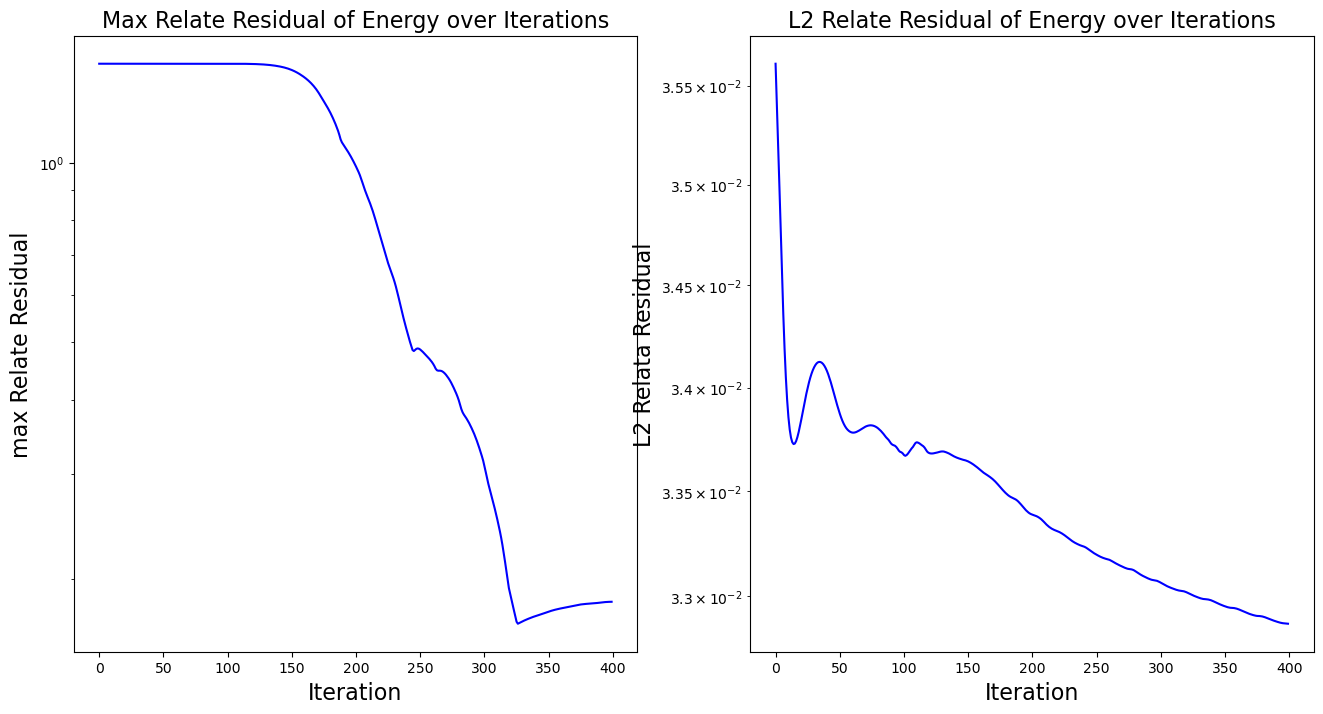

In [14]:
import matplotlib.pyplot as plt 
# 绘制残差曲线

fig,axs = plt.subplots(1,2,figsize=(16,8))
axs[0].plot(max_residuals,color="blue")
axs[0].set_yscale('log')  # 对数尺度可以更清晰地展示收敛性
axs[0].set_xlabel('Iteration',fontsize=16)
axs[0].set_ylabel('max Relate Residual',fontsize=16)
axs[0].set_title('Max Relate Residual of Energy over Iterations',fontsize=16)

axs[1].plot(l2_residuals,color="blue")
axs[1].set_yscale('log')  # 对数尺度可以更清晰地展示收敛性
axs[1].set_xlabel('Iteration',fontsize=16)
axs[1].set_ylabel('L2 Relata Residual',fontsize=16)
axs[1].set_title('L2 Relate Residual of Energy over Iterations',fontsize=16)

plt.show()



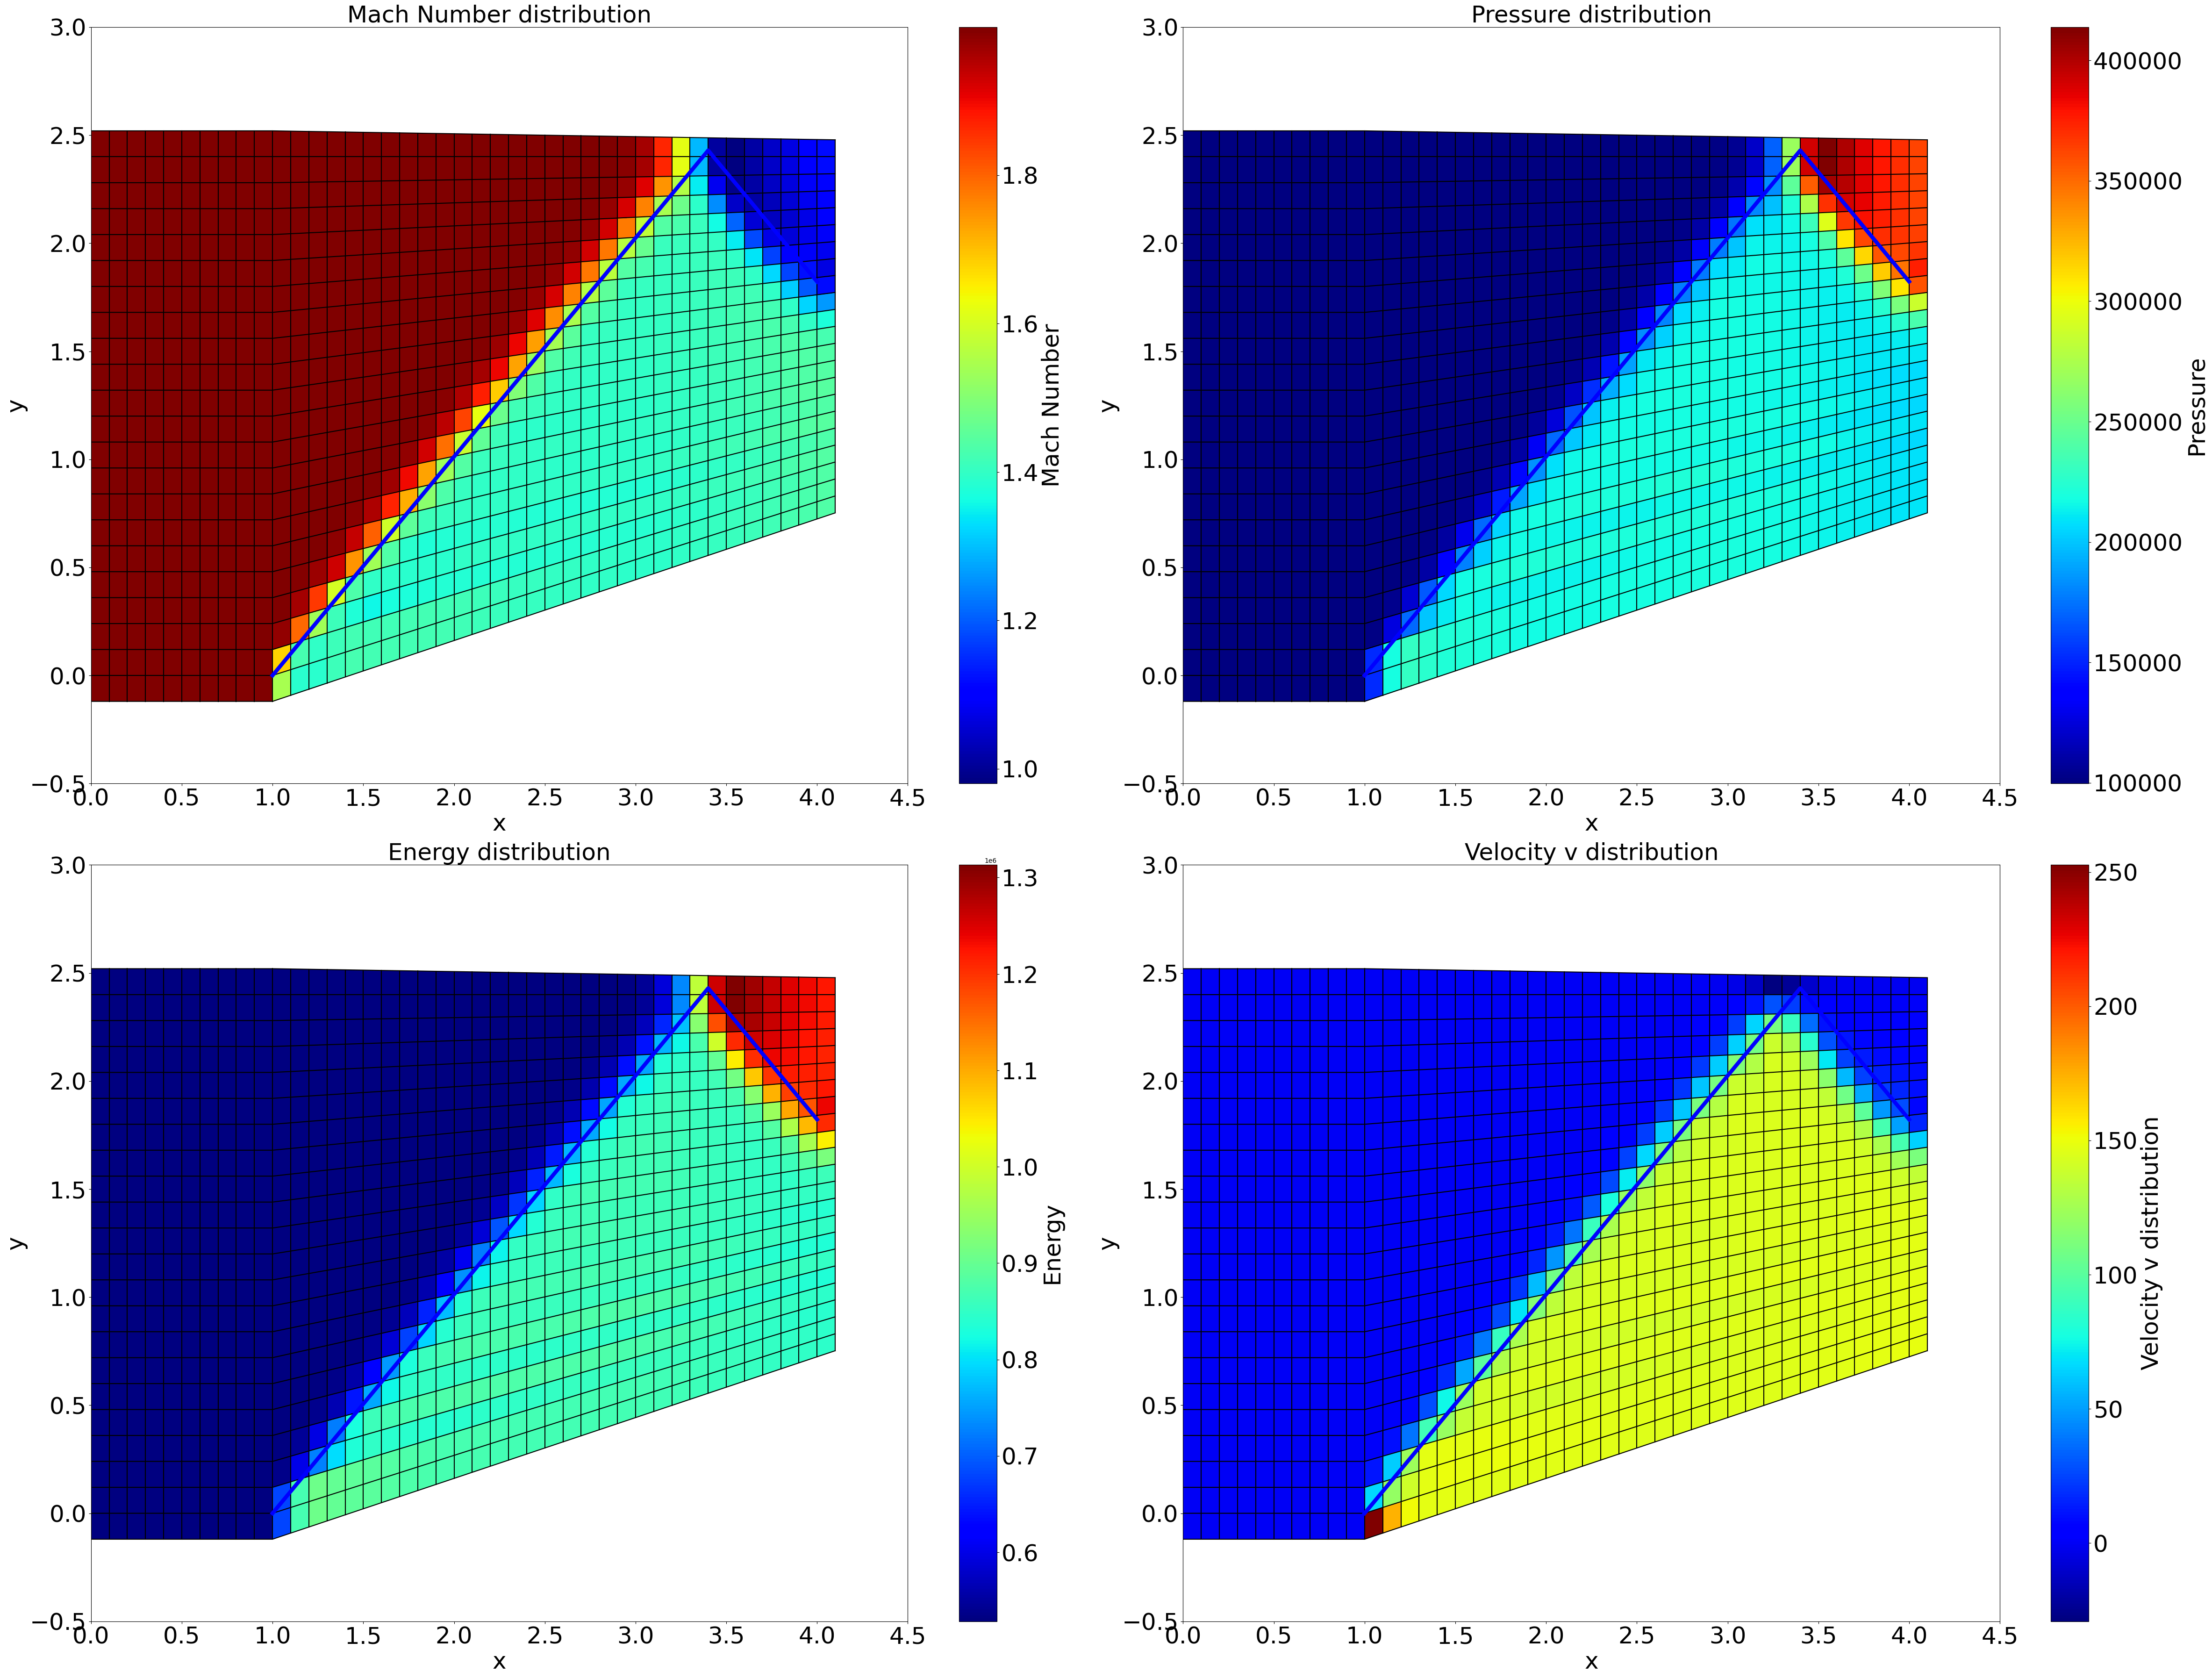

In [15]:
import matplotlib.pyplot as plt
from matplotlib import cm

# 可视化网格
fig, axs = plt.subplots(2, 2, figsize=(48, 36))

for i in range(nmax+1):
    axs[0,0].plot(bigx[i, :], bigy[i, :], 'k')
    axs[0,1].plot(bigx[i, :], bigy[i, :], 'k')
    axs[1,0].plot(bigx[i, :], bigy[i, :], 'k')
    axs[1,1].plot(bigx[i, :], bigy[i, :], 'k')
for j in range(mmax+1):
    axs[0,0].plot(bigx[:, j], bigy[:, j], 'k')
    axs[0,1].plot(bigx[:, j], bigy[:, j], 'k')
    axs[1,0].plot(bigx[:, j], bigy[:, j], 'k')
    axs[1,1].plot(bigx[:, j], bigy[:, j], 'k')

axs[0,0].plot(wave_x,wave_y,'blue',linewidth=6)
axs[0,1].plot(wave_x,wave_y,'blue',linewidth=6)
axs[1,0].plot(wave_x,wave_y,'blue',linewidth=6)
axs[1,1].plot(wave_x,wave_y,'blue',linewidth=6)

# 注意：确保U和p的数据结构正确
mech = axs[0,0].pcolormesh(bigx, bigy, u[:,:]/c[:,:], shading='auto', cmap='jet')  
cbar_mech = fig.colorbar(mech, ax=axs[0,0])
cbar_mech.set_label("Mach Number", fontsize=36)
cbar_mech.ax.tick_params(labelsize=36)

axs[0,0].set_title('Mach Number distribution', fontsize=36)
axs[0,0].set_xlabel('x', fontsize=36)
axs[0,0].set_ylabel('y', fontsize=36)
axs[0,0].set_xlim(0, 4.5)
axs[0,0].set_ylim(-0.5, 3)

pressure = axs[0,1].pcolormesh(bigx, bigy, p[:, :], shading='auto', cmap='jet')
cbar_pressure = fig.colorbar(pressure, ax=axs[0,1])
cbar_pressure.set_label("Pressure", fontsize=36)
cbar_pressure.ax.tick_params(labelsize=36)

axs[0,1].set_title('Pressure distribution', fontsize=36)
axs[0,1].set_xlabel('x', fontsize=36)
axs[0,1].set_ylabel('y', fontsize=36)
axs[0,1].set_xlim(0, 4.5)
axs[0,1].set_ylim(-0.5, 3)

energy = axs[1,0].pcolormesh(bigx, bigy, e[:,:], shading='auto', cmap='jet')
cbar_energy = fig.colorbar(energy, ax=axs[1,0])
cbar_energy.set_label("Energy", fontsize=36)
cbar_energy.ax.tick_params(labelsize=36)

axs[1,0].set_title('Energy distribution', fontsize=36)
axs[1,0].set_xlabel('x', fontsize=36)
axs[1,0].set_ylabel('y', fontsize=36)
axs[1,0].set_xlim(0, 4.5)
axs[1,0].set_ylim(-0.5, 3)

density = axs[1,1].pcolormesh(bigx, bigy, v[:, :], shading='auto', cmap='jet')
cbar_density = fig.colorbar(density, ax=axs[1,1])
cbar_density.set_label("Velocity v distribution", fontsize=36)
cbar_density.ax.tick_params(labelsize=36)

axs[1,1].set_title('Velocity v distribution', fontsize=36)
axs[1,1].set_xlabel('x', fontsize=36)
axs[1,1].set_ylabel('y', fontsize=36)
axs[1,1].set_xlim(0, 4.5)
axs[1,1].set_ylim(-0.5, 3)

# 设置刻度字体大小
for ax in axs:
    for a in ax:
        a.tick_params(labelsize=36)

plt.tight_layout()
plt.show()

